# 🅿️ Analisis Potensi Tarif Parkir Banyumas
## Klasifikasi Random Forest dengan Tarif Adaptif, Spatial Analysis & Simulasi Interaktif

**Tujuan**: Menganalisis potensi tarif parkir di berbagai lokasi di Banyumas menggunakan Random Forest classification dengan implementasi tarif progresif, mapping interaktif, dan sistem prediksi what-if.

**Dataset**: DataParkir_Fix.xlsx (parking locations, revenue, quantity, time data)

**Output Utama**:
- ✅ Model akurasi tinggi untuk Motor & Mobil
- ✅ Spatial map dengan tarif per lokasi
- ✅ Progressive tariff system (base + peak surcharge)
- ✅ Revenue estimation & ROI analysis
- ✅ Interactive what-if analysis
- ✅ Comprehensive visualization dashboard

## 9️⃣ FEATURE IMPORTANCE & INTERPRETATION

## 1️⃣ LIBRARY IMPORTS & SETUP

In [11]:
# Basic data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, time
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster, Search
from sklearn.tree import plot_tree

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✅ Semua library berhasil diimport")

✅ Semua library berhasil diimport


## 2️⃣ FUNCTION DECLARATIONS & UTILITY FUNCTIONS

In [12]:
# ===== TIME CONVERSION FUNCTIONS =====
def parse_time_to_decimal(time_str):
    """Convert time string (H.M or H:M format) to decimal hour"""
    if pd.isna(time_str) or time_str == '':
        return np.nan
    time_str = str(time_str).strip()
    try:
        # Try dot format first (20.30)
        if '.' in time_str:
            parts = time_str.split('.')
        else:
            parts = time_str.split(':')
        hours = int(parts[0])
        minutes = int(parts[1]) if len(parts) > 1 else 0
        return hours + minutes / 60.0
    except:
        return np.nan

def konversi_jam(jam_range):
    """Convert time range (20.00-22.00) to average decimal hour"""
    if pd.isna(jam_range) or jam_range == '':
        return np.nan
    jam_range = str(jam_range).strip()
    try:
        parts = jam_range.replace(':', '.').split('-')
        start = parse_time_to_decimal(parts[0])
        end = parse_time_to_decimal(parts[1])
        if pd.isna(start) or pd.isna(end):
            return np.nan
        # Handle midnight crossing
        if end < start:
            end += 24
        return (start + end) / 2.0
    except:
        return np.nan

def kategori_jam_otomatis(jam):
    """Categorize hour into traffic pattern"""
    if pd.isna(jam):
        return np.nan
    jam = jam % 24  # Handle midnight
    if 0 <= jam < 6 or 22 <= jam < 24:
        return 'Sepi'
    elif 6 <= jam < 9 or 17 <= jam < 22:
        return 'Sedang'
    else:
        return 'Ramai'

def time_to_decimal_hour(time_obj):
    """Convert datetime.time to decimal hour"""
    if pd.isna(time_obj):
        return np.nan
    return time_obj.hour + time_obj.minute / 60.0

# ===== TARIFF MAPPING =====
tarif_dasar_motor = {
    'Rendah': 1000,
    'Sedang': 2000,
    'Tinggi': 3000
}

tarif_dasar_mobil = {
    'Rendah': 3000,
    'Sedang': 4000,
    'Tinggi': 5000
}

def calculate_progresif_tarif(jam_desimal, kelas_tarif, vehicle_type='Motor'):
    """Calculate progressive tariff based on time and class"""
    tarif_mapping = tarif_dasar_motor if vehicle_type == 'Motor' else tarif_dasar_mobil
    base_tariff = tarif_mapping.get(kelas_tarif, 0)
    
    # Peak hour surcharge: +25% from 9 to 17
    is_peak = 9 <= jam_desimal < 17
    surcharge = 1.25 if is_peak else 1.0
    
    return int(base_tariff * surcharge)

print("✅ Semua utility functions telah dideklarasikan")

✅ Semua utility functions telah dideklarasikan


## 3️⃣ DATA LOADING & EXPLORATION

In [13]:
# Load data
file_path = 'd:\\TarifProgresifParkirBanyumas\\DataParkir_Fix.xlsx'
df_raw = pd.read_excel(file_path)

print("="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"Shape: {df_raw.shape}")
print(f"\nColumn Names:")
print(df_raw.columns.tolist())
print(f"\nFirst few rows:")
print(df_raw.head())
print(f"\nData types:")
print(df_raw.dtypes)
print(f"\nMissing values:")
print(df_raw.isnull().sum())

DATA OVERVIEW
Shape: (407, 39)

Column Names:
['Titik', 'Latitude', 'Longitude', 'Jam Ramai Mobil Weekday', 'Jam Ramai Motor Weekend', 'Jam Ramai Mobil Weekend', 'Jam Ramai Motor Weekday', 'Jam Sedang Motor Weekday', 'Jam Sedang Mobil Weekday', 'Jam Sedang Motor Weekend', 'Jam Sedang Mobil Weekend', 'Jam Sepi Motor Weekday', 'Jam Sepi Mobil Weekday', 'Jam Sepi Motor Weekend', 'Jam Sepi Mobil Weekend', 'Pendapatan Tarif Parkir Weekday Motor', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Pendapatan Tarif Parkir Weekday Mobil', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Pendapatan Tarif Parkir Weekend Motor', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Pendapatan Tarif Parkir Weekend Mobil', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Pendapatan Tarif Parkir Weekday Motor per tahun', 'Pendapatan Tarif Parkir Weekday Mobil per tahun', 'Pendapatan Tarif Parkir Weekend Motor per tahun', 'Pendapatan Tarif Parkir Weekend Mobil per tahun', 'Jumlah Motor Weekday', 'Jumlah Mobil Weekday',

## 4️⃣ DATA CLEANING - REVENUE CONVERSION

In [14]:
# Identify revenue columns (containing 'Pend')
pend_cols = [col for col in df_raw.columns if 'Pend' in col]

print("Revenue columns to clean:", pend_cols)

# Clean revenue columns - remove 'Rp' and convert to numeric
for col in pend_cols:
    # Remove 'Rp' prefix if exists
    df_raw[col] = df_raw[col].astype(str).str.replace('Rp ', '', regex=False)
    # Replace comma with dot for decimal
    df_raw[col] = df_raw[col].str.replace(',', '.')
    # Remove dots used as thousands separator (keep only last dot)
    df_raw[col] = df_raw[col].str.replace('.', '', -1).str.replace('.', '', -1)
    # Coerce to numeric
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')

print("\n✅ Revenue columns converted to numeric")
print(df_raw[pend_cols].head())

Revenue columns to clean: ['Pendapatan Tarif Parkir Weekday Motor', 'Pendapatan Tarif Parkir Weekday Mobil', 'Pendapatan Tarif Parkir Weekend Motor', 'Pendapatan Tarif Parkir Weekend Mobil', 'Pendapatan Tarif Parkir Weekday Motor per tahun', 'Pendapatan Tarif Parkir Weekday Mobil per tahun', 'Pendapatan Tarif Parkir Weekend Motor per tahun', 'Pendapatan Tarif Parkir Weekend Mobil per tahun']

✅ Revenue columns converted to numeric
   Pendapatan Tarif Parkir Weekday Motor  \
0                                    NaN   
1                                   57.0   
2                                   78.0   
3                                   84.0   
4                                  113.0   

   Pendapatan Tarif Parkir Weekday Mobil  \
0                                    NaN   
1                                   26.0   
2                                   48.0   
3                                   58.0   
4                                   70.0   

   Pendapatan Tarif Parkir Weekend 

## 5️⃣ DATA CLEANING - TIME CONVERSION & IMPUTATION

In [15]:
# Identify time columns (containing 'Jam')
jam_cols = [col for col in df_raw.columns if 'Jam' in col]

print("Time columns to process:", jam_cols)

# Convert time ranges to decimal hours
for col in jam_cols:
    df_raw[col] = df_raw[col].apply(konversi_jam)

# Impute missing time values with median
for col in jam_cols:
    median_val = df_raw[col].median()
    df_raw[col].fillna(median_val, inplace=True)

print("\n✅ Time columns converted and imputed")
print(df_raw[jam_cols].head())

Time columns to process: ['Jam Ramai Mobil Weekday', 'Jam Ramai Motor Weekend', 'Jam Ramai Mobil Weekend', 'Jam Ramai Motor Weekday', 'Jam Sedang Motor Weekday', 'Jam Sedang Mobil Weekday', 'Jam Sedang Motor Weekend', 'Jam Sedang Mobil Weekend', 'Jam Sepi Motor Weekday', 'Jam Sepi Mobil Weekday', 'Jam Sepi Motor Weekend', 'Jam Sepi Mobil Weekend']

✅ Time columns converted and imputed
   Jam Ramai Mobil Weekday  Jam Ramai Motor Weekend  Jam Ramai Mobil Weekend  \
0                     14.0                     14.0                     14.0   
1                     16.0                     16.0                     16.0   
2                     15.0                     15.0                     15.0   
3                     14.0                     14.0                     14.0   
4                     19.5                     19.5                     19.5   

   Jam Ramai Motor Weekday  Jam Sedang Motor Weekday  \
0                     14.0                      15.0   
1                  

## 6️⃣ DATA CLEANING - NUMERIC & CATEGORICAL IMPUTATION

In [16]:
# Identify numeric columns (Jumlah = quantity)
jumlah_cols = [col for col in df_raw.columns if 'Jumlah' in col]

print("Quantity columns:", jumlah_cols)

# Impute numeric columns with median
for col in jumlah_cols:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
    median_val = df_raw[col].median()
    df_raw[col].fillna(median_val, inplace=True)

# Impute categorical columns with mode
categorical_cols = df_raw.select_dtypes(include=['object']).columns
for col in categorical_cols:
    mode_val = df_raw[col].mode()[0] if not df_raw[col].mode().empty else 'Unknown'
    df_raw[col].fillna(mode_val, inplace=True)

print("\n✅ Numeric dan categorical imputation selesai")
print(f"Remaining missing values: {df_raw.isnull().sum().sum()}")

Quantity columns: ['Jumlah Motor Weekday', 'Jumlah Mobil Weekday', 'Jumlah Motor Weekend', 'Jumlah Mobil Weekend']

✅ Numeric dan categorical imputation selesai
Remaining missing values: 74


## 7️⃣ SPATIAL DATA HANDLING

In [17]:
# Filter data with complete spatial information
df_spasial = df_raw[
    (df_raw['Titik'].notna()) & 
    (df_raw['Latitude'].notna()) & 
    (df_raw['Longitude'].notna())
].copy()

df_spasial['Latitude'] = pd.to_numeric(df_spasial['Latitude'], errors='coerce')
df_spasial['Longitude'] = pd.to_numeric(df_spasial['Longitude'], errors='coerce')

# Keep only valid coordinates
df_spasial = df_spasial[df_spasial['Latitude'].notna() & df_spasial['Longitude'].notna()]

print("="*60)
print("SPATIAL DATA SUMMARY")
print("="*60)
print(f"Total locations with coordinates: {len(df_spasial)}")
print(f"\nUnique locations: {df_spasial['Titik'].nunique()}")
print(f"\nLocation names:")
print(df_spasial['Titik'].unique()[:10])

SPATIAL DATA SUMMARY
Total locations with coordinates: 401

Unique locations: 391

Location names:
['Toko Satria' 'Toko Mlati' 'Toko Pagoda' 'Matahari Bazzar' 'Toko Bata'
 'Kebondalam/Rita Pa' 'Gerai Indosat' 'Toko Cinderela' 'Toko Daerah'
 'Toko Listrik Kebondalem']


## 8️⃣ FEATURE ENGINEERING & TARGET DEFINITION

In [37]:
# Calculate total revenue for each vehicle type
motor_pend_cols = [col for col in pend_cols if 'Motor' in col]
mobil_pend_cols = [col for col in pend_cols if 'Mobil' in col]

df_spasial['Total_Pend_Motor'] = df_spasial[motor_pend_cols].sum(axis=1)
df_spasial['Total_Pend_Mobil'] = df_spasial[mobil_pend_cols].sum(axis=1)

# Define features EXACTLY like app.py:
# fitur = ['Jumlah X Weekday', 'Jumlah X Weekend'] + [jam columns that match vehicle type]
fitur_motor = ['Jumlah Motor Weekday', 'Jumlah Motor Weekend'] + [c for c in jam_cols if 'Motor' in c]
fitur_mobil = ['Jumlah Mobil Weekday', 'Jumlah Mobil Weekend'] + [c for c in jam_cols if 'Mobil' in c]

print("Motor features:", fitur_motor)
print("\nMobil features:", fitur_mobil)

# Create target variable using quantile-based binning
df_spasial['Target_Motor'] = pd.qcut(df_spasial['Total_Pend_Motor'], 
                                       q=3, labels=['Rendah', 'Sedang', 'Tinggi'])
df_spasial['Target_Mobil'] = pd.qcut(df_spasial['Total_Pend_Mobil'], 
                                       q=3, labels=['Rendah', 'Sedang', 'Tinggi'])

print("\n✅ Features dan target berhasil didefinisikan")
print(f"\nTarget distribution (Motor): \n{df_spasial['Target_Motor'].value_counts()}")
print(f"\nTarget distribution (Mobil): \n{df_spasial['Target_Mobil'].value_counts()}")

Motor features: ['Jumlah Motor Weekday', 'Jumlah Motor Weekend', 'Jam Ramai Motor Weekend', 'Jam Ramai Motor Weekday', 'Jam Sedang Motor Weekday', 'Jam Sedang Motor Weekend', 'Jam Sepi Motor Weekday', 'Jam Sepi Motor Weekend']

Mobil features: ['Jumlah Mobil Weekday', 'Jumlah Mobil Weekend', 'Jam Ramai Mobil Weekday', 'Jam Ramai Mobil Weekend', 'Jam Sedang Mobil Weekday', 'Jam Sedang Mobil Weekend', 'Jam Sepi Mobil Weekday', 'Jam Sepi Mobil Weekend']

✅ Features dan target berhasil didefinisikan

Target distribution (Motor): 
Target_Motor
Rendah    134
Tinggi    134
Sedang    133
Name: count, dtype: int64

Target distribution (Mobil): 
Target_Mobil
Rendah    134
Tinggi    134
Sedang    133
Name: count, dtype: int64


## 9️⃣ EXPLORATORY DATA ANALYSIS (EDA)

## 📊 SECTION 8.5: KUANTIL PENDAPATAN TAHUNAN (ANNUAL REVENUE BOUNDARIES)

💰 BATAS KUANTIL TOTAL PENDAPATAN TAHUNAN (Rp)

🏍️  BATAS KUANTIL MOTOR
Rendah  : Pendapatan < Rp101,260,884
Sedang  : Rp101,260,884 s/d Rp186,272,000
Tinggi  : Pendapatan > Rp186,272,000


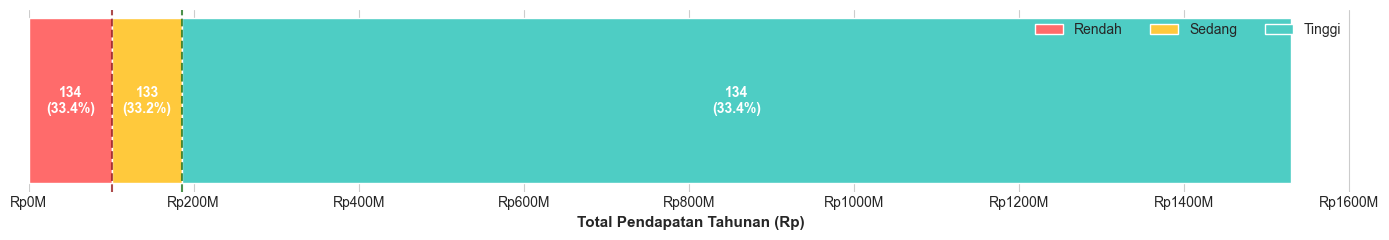


🚗 BATAS KUANTIL MOBIL
Rendah  : Pendapatan < Rp9,674,400
Sedang  : Rp9,674,400 s/d Rp16,416,861
Tinggi  : Pendapatan > Rp16,416,861


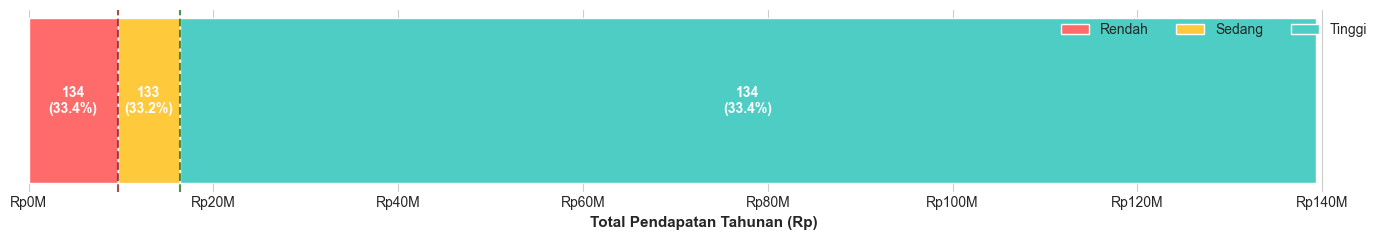


✅ Kuantil Boundaries divisualisasikan


In [36]:
print("=" * 80)
print("💰 BATAS KUANTIL TOTAL PENDAPATAN TAHUNAN (Rp)")
print("=" * 80)

# Calculate quantile boundaries for Motor
try:
    batas_motor = df_spasial['Total_Pend_Motor'].quantile([0.333, 0.666]).drop_duplicates().sort_values()
except:
    batas_motor = None

# Calculate quantile boundaries for Mobil
try:
    batas_mobil = df_spasial['Total_Pend_Mobil'].quantile([0.333, 0.666]).drop_duplicates().sort_values()
except:
    batas_mobil = None

# Display Motor boundaries
print("\n🏍️  BATAS KUANTIL MOTOR")
if batas_motor is not None and len(batas_motor) == 2:
    b1_motor = batas_motor.iloc[0]
    b2_motor = batas_motor.iloc[1]
    print(f"Rendah  : Pendapatan < Rp{b1_motor:,.0f}")
    print(f"Sedang  : Rp{b1_motor:,.0f} s/d Rp{b2_motor:,.0f}")
    print(f"Tinggi  : Pendapatan > Rp{b2_motor:,.0f}")
    
    # Visualisasi Motor
    fig_motor, ax_motor = plt.subplots(figsize=(14, 2.5), dpi=100)
    
    min_val = 0
    max_val = df_spasial['Total_Pend_Motor'].max()
    
    # Stacked bar chart
    ax_motor.barh(['Motor'], [b1_motor - min_val], left=min_val, color='#FF6B6B', height=0.4, label='Rendah')
    ax_motor.barh(['Motor'], [b2_motor - b1_motor], left=b1_motor, color='#FFC93C', height=0.4, label='Sedang')
    ax_motor.barh(['Motor'], [max_val - b2_motor], left=b2_motor, color='#4ECDC4', height=0.4, label='Tinggi')
    
    # Grid lines
    ax_motor.axvline(b1_motor, color='darkred', linestyle='--', linewidth=1.5, alpha=0.7)
    ax_motor.axvline(b2_motor, color='darkgreen', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Count data in each category
    cnt_rendah = (df_spasial['Total_Pend_Motor'] < b1_motor).sum()
    cnt_sedang = ((df_spasial['Total_Pend_Motor'] >= b1_motor) & (df_spasial['Total_Pend_Motor'] < b2_motor)).sum()
    cnt_tinggi = (df_spasial['Total_Pend_Motor'] >= b2_motor).sum()
    total = len(df_spasial)
    
    # Text annotations
    ax_motor.text((min_val + b1_motor) / 2, 0, f'{cnt_rendah}\n({100*cnt_rendah/total:.1f}%)', 
                  ha='center', va='center', fontweight='bold', fontsize=10, color='white')
    ax_motor.text((b1_motor + b2_motor) / 2, 0, f'{cnt_sedang}\n({100*cnt_sedang/total:.1f}%)', 
                  ha='center', va='center', fontweight='bold', fontsize=10, color='white')
    ax_motor.text((b2_motor + max_val) / 2, 0, f'{cnt_tinggi}\n({100*cnt_tinggi/total:.1f}%)', 
                  ha='center', va='center', fontweight='bold', fontsize=10, color='white')
    
    ax_motor.set_xlabel('Total Pendapatan Tahunan (Rp)', fontsize=11, fontweight='bold')
    ax_motor.set_xlim(min_val, max_val * 1.05)
    ax_motor.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'Rp{x/1e6:.0f}M'))
    ax_motor.legend(loc='upper right', fontsize=10, ncol=3)
    ax_motor.set_yticks([])
    plt.tight_layout()
    plt.show()

# Display Mobil boundaries
print("\n🚗 BATAS KUANTIL MOBIL")
if batas_mobil is not None and len(batas_mobil) == 2:
    b1_mobil = batas_mobil.iloc[0]
    b2_mobil = batas_mobil.iloc[1]
    print(f"Rendah  : Pendapatan < Rp{b1_mobil:,.0f}")
    print(f"Sedang  : Rp{b1_mobil:,.0f} s/d Rp{b2_mobil:,.0f}")
    print(f"Tinggi  : Pendapatan > Rp{b2_mobil:,.0f}")
    
    # Visualisasi Mobil
    fig_mobil, ax_mobil = plt.subplots(figsize=(14, 2.5), dpi=100)
    
    min_val = 0
    max_val = df_spasial['Total_Pend_Mobil'].max()
    
    # Stacked bar chart
    ax_mobil.barh(['Mobil'], [b1_mobil - min_val], left=min_val, color='#FF6B6B', height=0.4, label='Rendah')
    ax_mobil.barh(['Mobil'], [b2_mobil - b1_mobil], left=b1_mobil, color='#FFC93C', height=0.4, label='Sedang')
    ax_mobil.barh(['Mobil'], [max_val - b2_mobil], left=b2_mobil, color='#4ECDC4', height=0.4, label='Tinggi')
    
    # Grid lines
    ax_mobil.axvline(b1_mobil, color='darkred', linestyle='--', linewidth=1.5, alpha=0.7)
    ax_mobil.axvline(b2_mobil, color='darkgreen', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Count data in each category
    cnt_rendah = (df_spasial['Total_Pend_Mobil'] < b1_mobil).sum()
    cnt_sedang = ((df_spasial['Total_Pend_Mobil'] >= b1_mobil) & (df_spasial['Total_Pend_Mobil'] < b2_mobil)).sum()
    cnt_tinggi = (df_spasial['Total_Pend_Mobil'] >= b2_mobil).sum()
    total = len(df_spasial)
    
    # Text annotations
    ax_mobil.text((min_val + b1_mobil) / 2, 0, f'{cnt_rendah}\n({100*cnt_rendah/total:.1f}%)', 
                  ha='center', va='center', fontweight='bold', fontsize=10, color='white')
    ax_mobil.text((b1_mobil + b2_mobil) / 2, 0, f'{cnt_sedang}\n({100*cnt_sedang/total:.1f}%)', 
                  ha='center', va='center', fontweight='bold', fontsize=10, color='white')
    ax_mobil.text((b2_mobil + max_val) / 2, 0, f'{cnt_tinggi}\n({100*cnt_tinggi/total:.1f}%)', 
                  ha='center', va='center', fontweight='bold', fontsize=10, color='white')
    
    ax_mobil.set_xlabel('Total Pendapatan Tahunan (Rp)', fontsize=11, fontweight='bold')
    ax_mobil.set_xlim(min_val, max_val * 1.05)
    ax_mobil.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'Rp{x/1e6:.0f}M'))
    ax_mobil.legend(loc='upper right', fontsize=10, ncol=3)
    ax_mobil.set_yticks([])
    plt.tight_layout()
    plt.show()

print("\n✅ Kuantil Boundaries divisualisasikan")

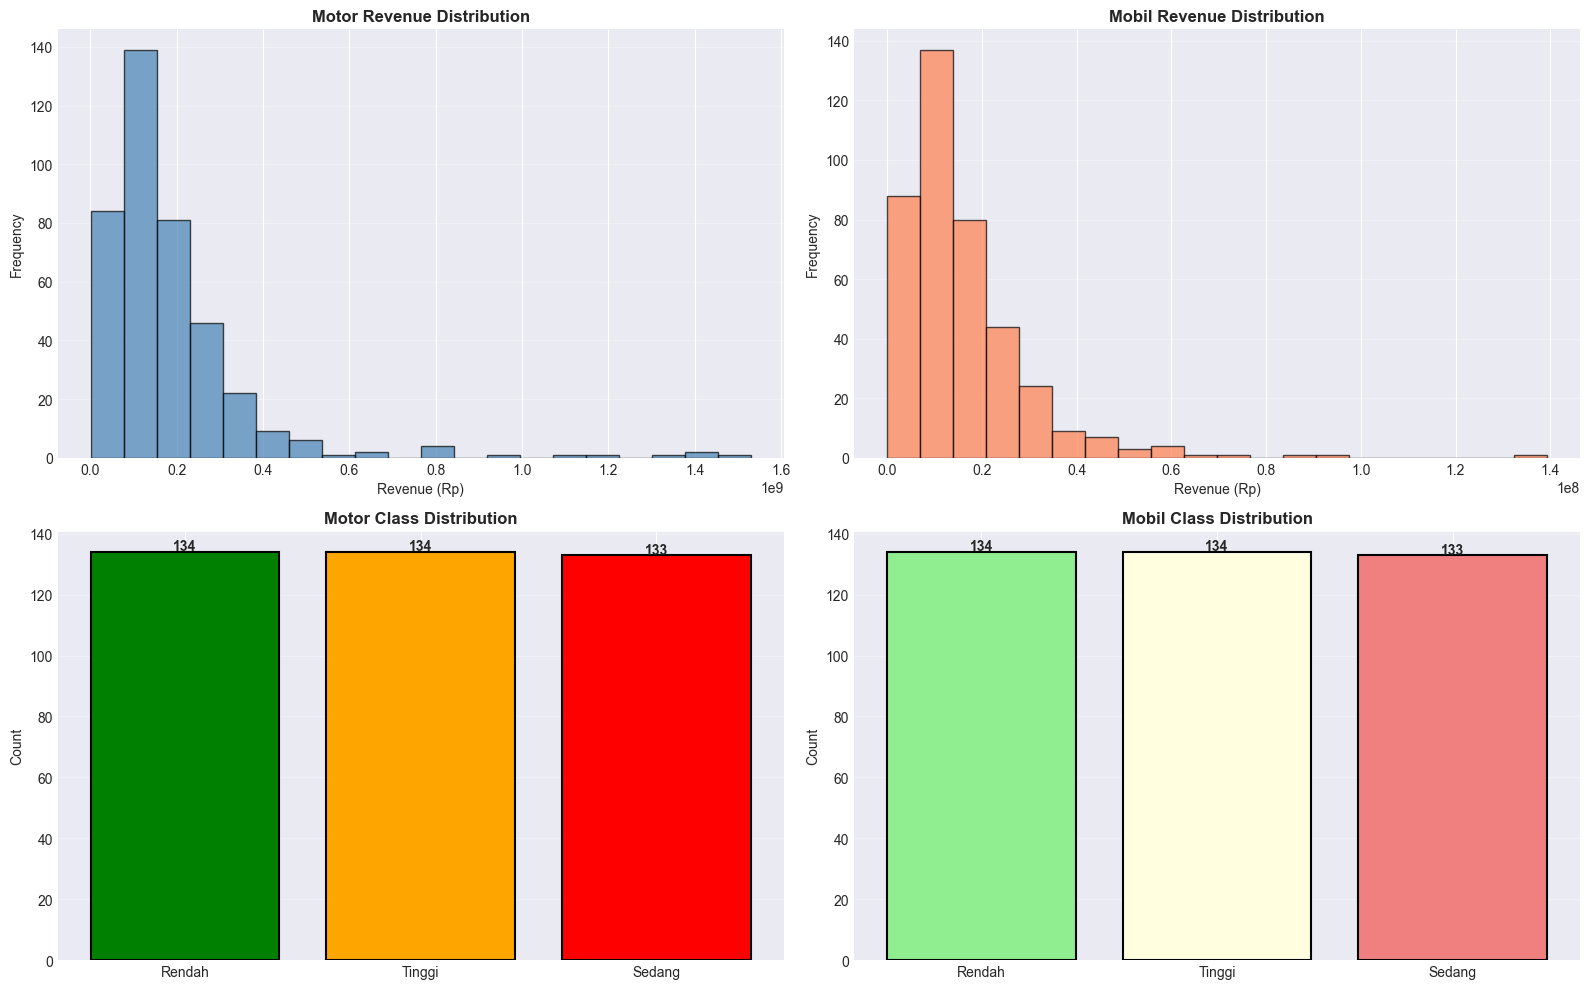

✅ EDA visualizations generated


In [19]:
# Revenue distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Motor revenue histogram
axes[0, 0].hist(df_spasial['Total_Pend_Motor'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Motor Revenue Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Revenue (Rp)', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].grid(alpha=0.3, axis='y')

# Mobil revenue histogram
axes[0, 1].hist(df_spasial['Total_Pend_Mobil'], bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Mobil Revenue Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Revenue (Rp)', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].grid(alpha=0.3, axis='y')

# Motor class distribution
motor_counts = df_spasial['Target_Motor'].value_counts()
axes[1, 0].bar(motor_counts.index, motor_counts.values, color=['green', 'orange', 'red'], edgecolor='black', linewidth=1.5)
axes[1, 0].set_title('Motor Class Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Count', fontsize=10)
axes[1, 0].grid(alpha=0.3, axis='y')
for i, (idx, val) in enumerate(motor_counts.items()):
    axes[1, 0].text(i, val + 0.5, str(val), ha='center', fontweight='bold')

# Mobil class distribution
mobil_counts = df_spasial['Target_Mobil'].value_counts()
axes[1, 1].bar(mobil_counts.index, mobil_counts.values, color=['lightgreen', 'lightyellow', 'lightcoral'], edgecolor='black', linewidth=1.5)
axes[1, 1].set_title('Mobil Class Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Count', fontsize=10)
axes[1, 1].grid(alpha=0.3, axis='y')
for i, (idx, val) in enumerate(mobil_counts.items()):
    axes[1, 1].text(i, val + 0.5, str(val), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ EDA visualizations generated")

TOP 10 FEATURE IMPORTANCE - MOTOR
                 Feature  Importance
    Jumlah Motor Weekday    0.530886
    Jumlah Motor Weekend    0.303330
 Jam Ramai Motor Weekday    0.036783
 Jam Ramai Motor Weekend    0.028265
  Jam Sepi Motor Weekday    0.027999
  Jam Sepi Motor Weekend    0.026733
Jam Sedang Motor Weekday    0.025362
Jam Sedang Motor Weekend    0.020641

TOP 10 FEATURE IMPORTANCE - MOBIL
                 Feature  Importance
    Jumlah Mobil Weekday    0.530463
    Jumlah Mobil Weekend    0.324412
  Jam Sepi Mobil Weekend    0.027532
Jam Sedang Mobil Weekday    0.025729
 Jam Ramai Mobil Weekend    0.023902
  Jam Sepi Mobil Weekday    0.023616
Jam Sedang Mobil Weekend    0.022563
 Jam Ramai Mobil Weekday    0.021783


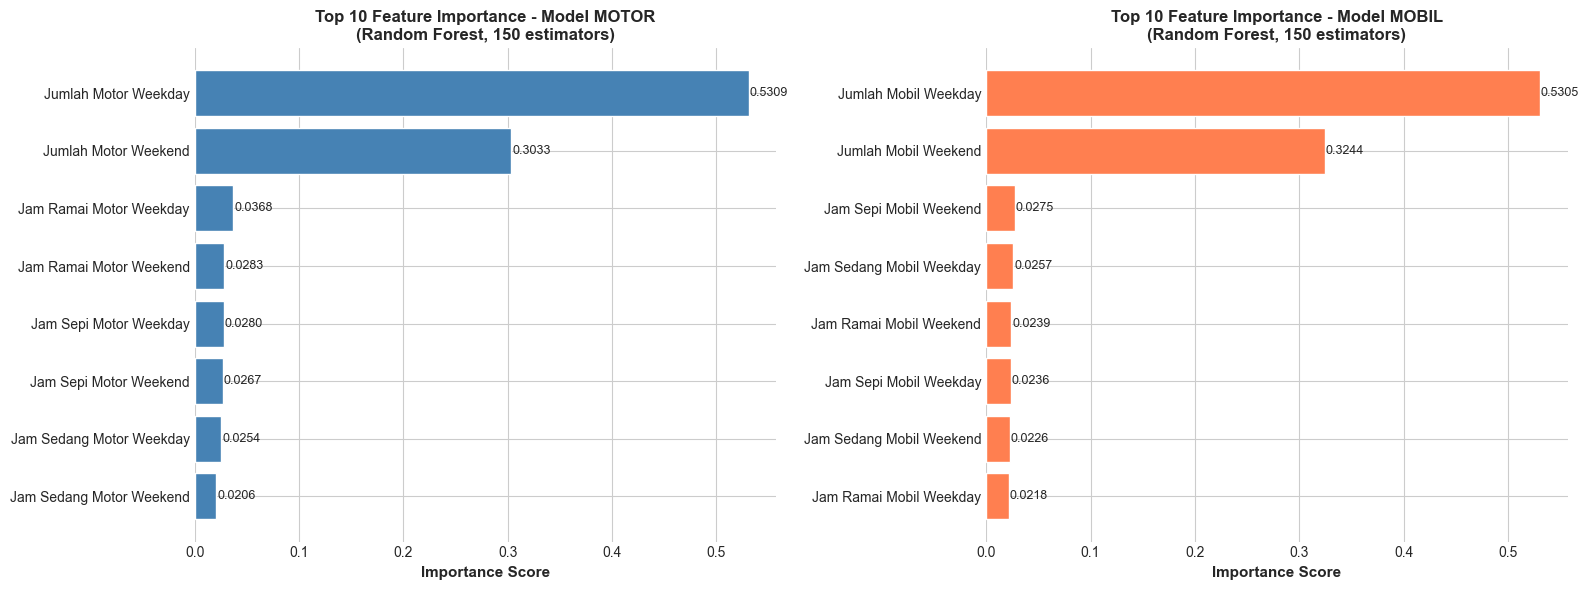


✅ Feature Importance dianalisis untuk kedua model


In [25]:
# Extract feature importance dari kedua model
feature_importance_motor = pd.DataFrame({
    'Feature': fitur_motor,
    'Importance': model_motor.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance_mobil = pd.DataFrame({
    'Feature': fitur_mobil,
    'Importance': model_mobil.feature_importances_
}).sort_values('Importance', ascending=False)

print("="*60)
print("TOP 10 FEATURE IMPORTANCE - MOTOR")
print("="*60)
print(feature_importance_motor.head(10).to_string(index=False))
print("\n" + "="*60)
print("TOP 10 FEATURE IMPORTANCE - MOBIL")
print("="*60)
print(feature_importance_mobil.head(10).to_string(index=False))

# Visualisasi Feature Importance - Motor vs Mobil
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Motor
axes[0].barh(feature_importance_motor['Feature'].head(10), 
             feature_importance_motor['Importance'].head(10), color='steelblue')
axes[0].set_xlabel('Importance Score', fontsize=11, fontweight='bold')
axes[0].set_title('Top 10 Feature Importance - Model MOTOR\n(Random Forest, 150 estimators)', 
                  fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
for i, v in enumerate(feature_importance_motor['Importance'].head(10)):
    axes[0].text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=9)

# Mobil
axes[1].barh(feature_importance_mobil['Feature'].head(10), 
             feature_importance_mobil['Importance'].head(10), color='coral')
axes[1].set_xlabel('Importance Score', fontsize=11, fontweight='bold')
axes[1].set_title('Top 10 Feature Importance - Model MOBIL\n(Random Forest, 150 estimators)', 
                  fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
for i, v in enumerate(feature_importance_mobil['Importance'].head(10)):
    axes[1].text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Feature Importance dianalisis untuk kedua model")

## 🔟 DECISION TREE VISUALIZATION

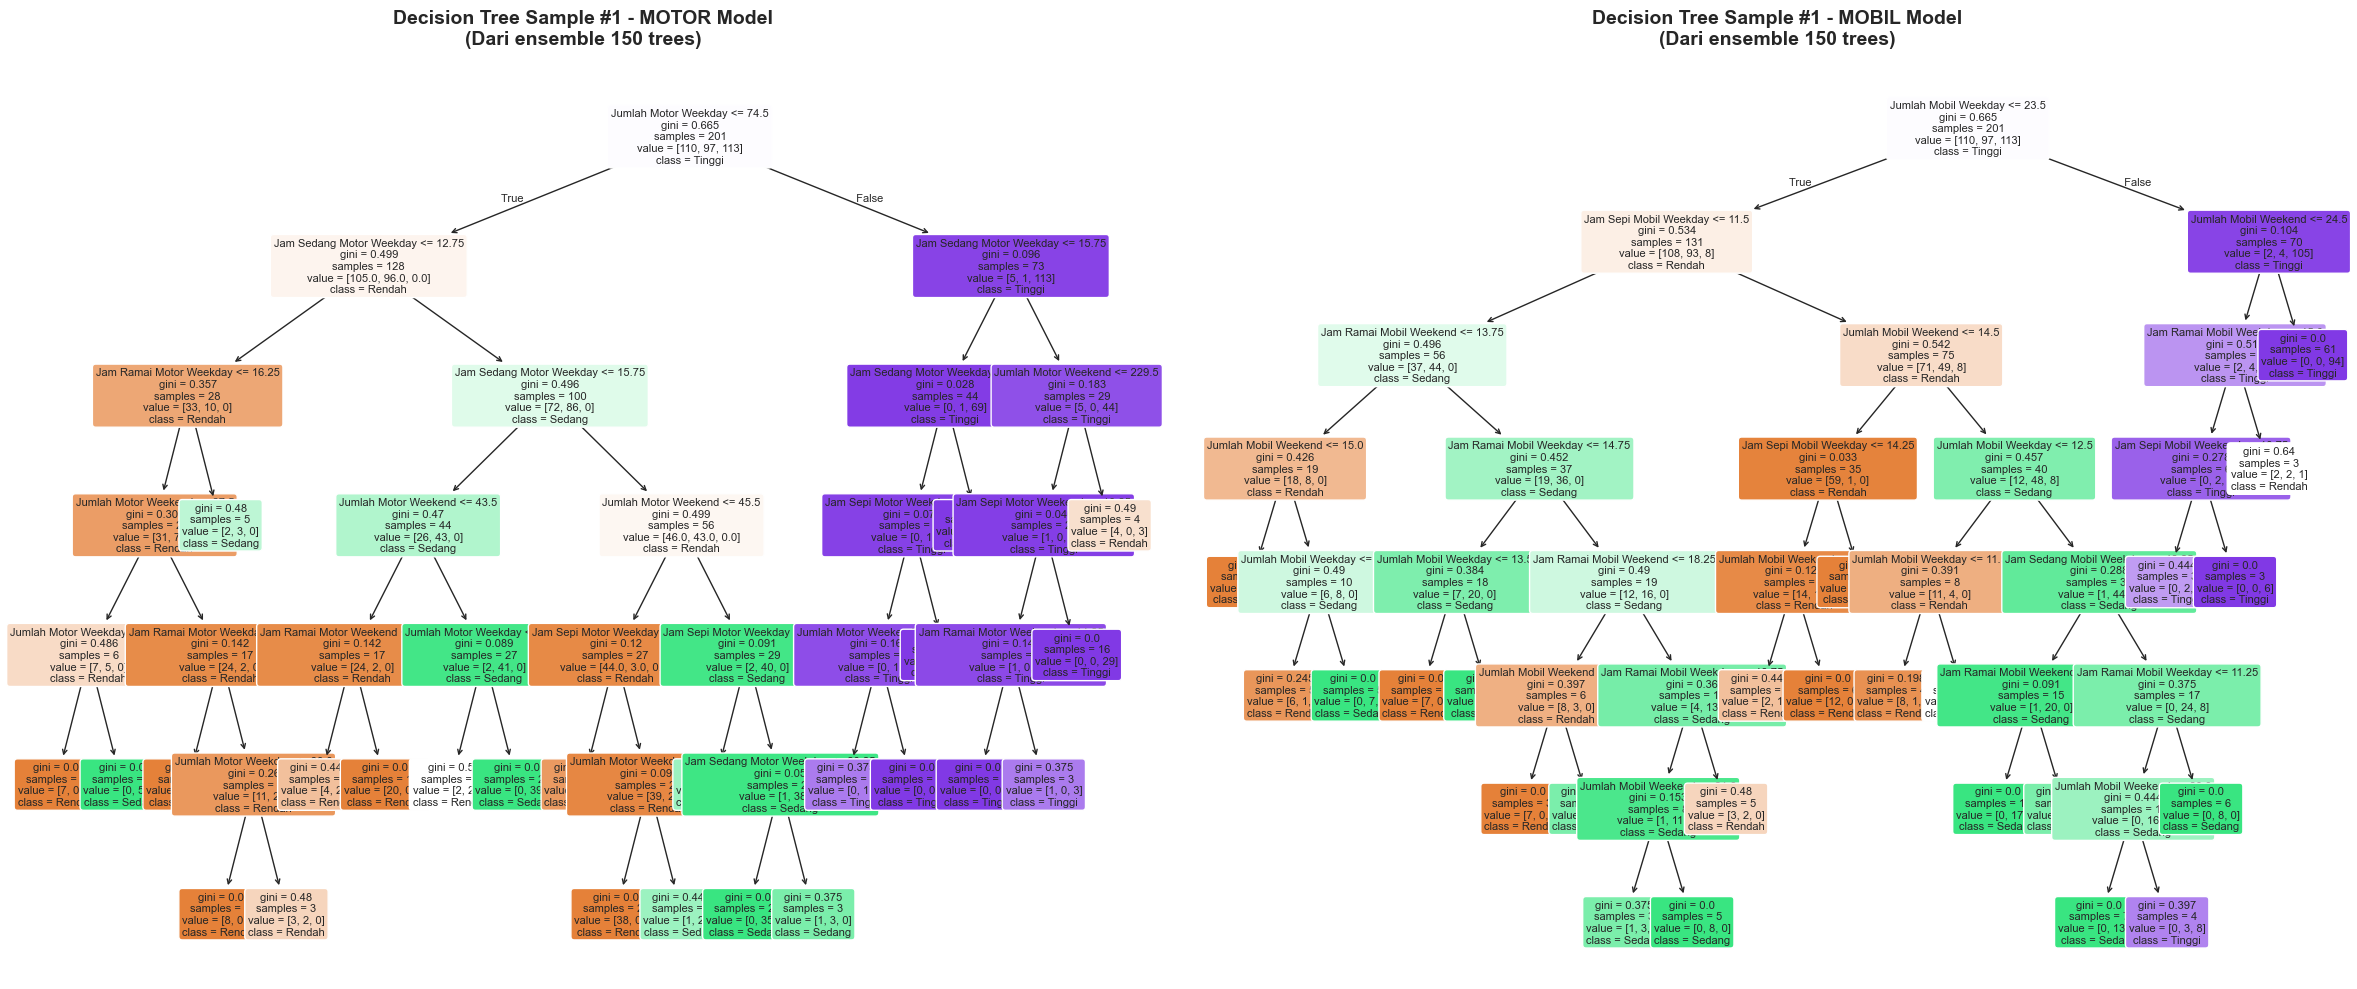

DECISION TREE STRUCTURE INFORMATION

🏍️  MOTOR Model Tree #1:
   Depth: 6
   N Leaves: 24
   Feature at root: Jumlah Motor Weekday

🚗 MOBIL Model Tree #1:
   Depth: 7
   N Leaves: 24
   Feature at root: Jumlah Mobil Weekday

✅ Decision Tree struktur divisualisasikan


In [26]:
from sklearn.tree import plot_tree

# Visualisasi Decision Tree - Ambil tree pertama dari ensemble untuk dianalisis
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Motor - Tree pertama
plot_tree(model_motor.estimators_[0], 
          feature_names=fitur_motor,
          class_names=le_motor.classes_,
          filled=True, 
          rounded=True,
          fontsize=8,
          ax=axes[0])
axes[0].set_title('Decision Tree Sample #1 - MOTOR Model\n(Dari ensemble 150 trees)', 
                  fontsize=14, fontweight='bold', pad=20)

# Mobil - Tree pertama
plot_tree(model_mobil.estimators_[0], 
          feature_names=fitur_mobil,
          class_names=le_mobil.classes_,
          filled=True, 
          rounded=True,
          fontsize=8,
          ax=axes[1])
axes[1].set_title('Decision Tree Sample #1 - MOBIL Model\n(Dari ensemble 150 trees)', 
                  fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Informasi struktur tree
print("="*60)
print("DECISION TREE STRUCTURE INFORMATION")
print("="*60)
print(f"\n🏍️  MOTOR Model Tree #1:")
print(f"   Depth: {model_motor.estimators_[0].get_depth()}")
print(f"   N Leaves: {model_motor.estimators_[0].get_n_leaves()}")
print(f"   Feature at root: {fitur_motor[model_motor.estimators_[0].tree_.feature[0]]}")

print(f"\n🚗 MOBIL Model Tree #1:")
print(f"   Depth: {model_mobil.estimators_[0].get_depth()}")
print(f"   N Leaves: {model_mobil.estimators_[0].get_n_leaves()}")
print(f"   Feature at root: {fitur_mobil[model_mobil.estimators_[0].tree_.feature[0]]}")

print("\n✅ Decision Tree struktur divisualisasikan")

## 1️⃣1️⃣ ROC-AUC ANALYSIS & LEARNING CURVES

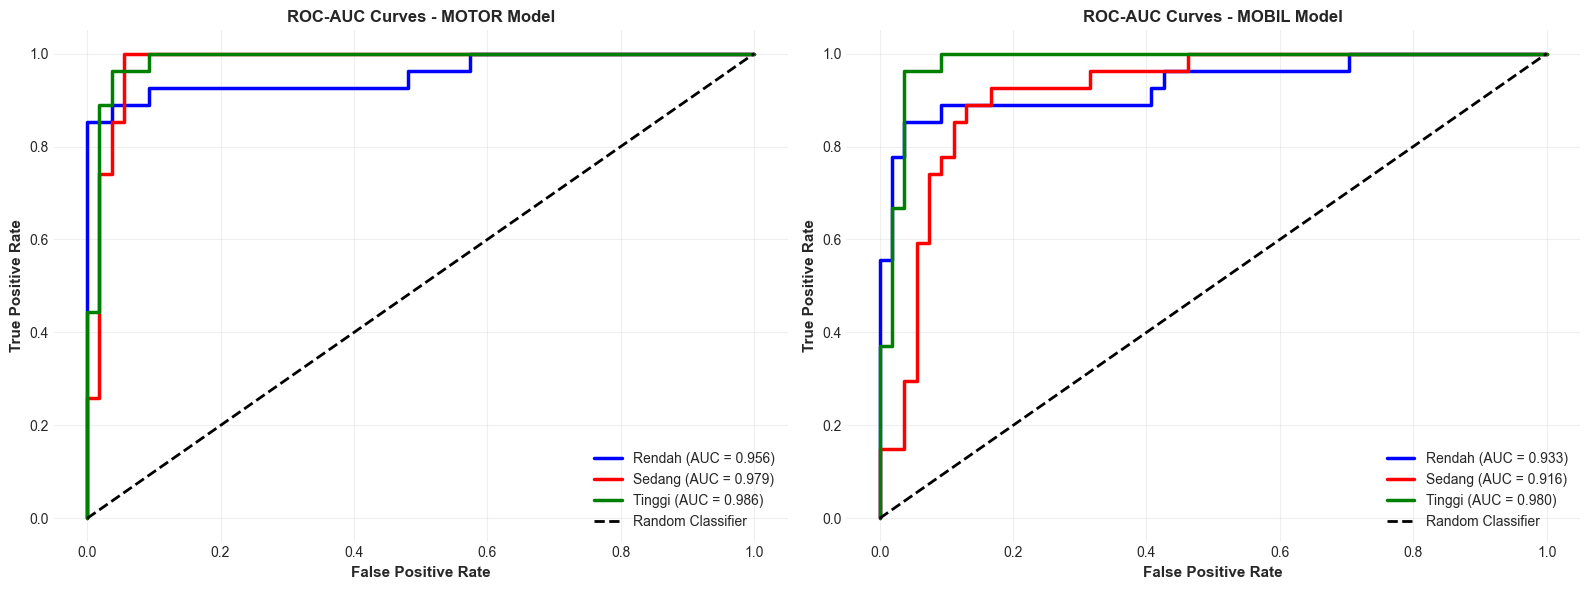


LEARNING CURVES - Evaluating model convergence


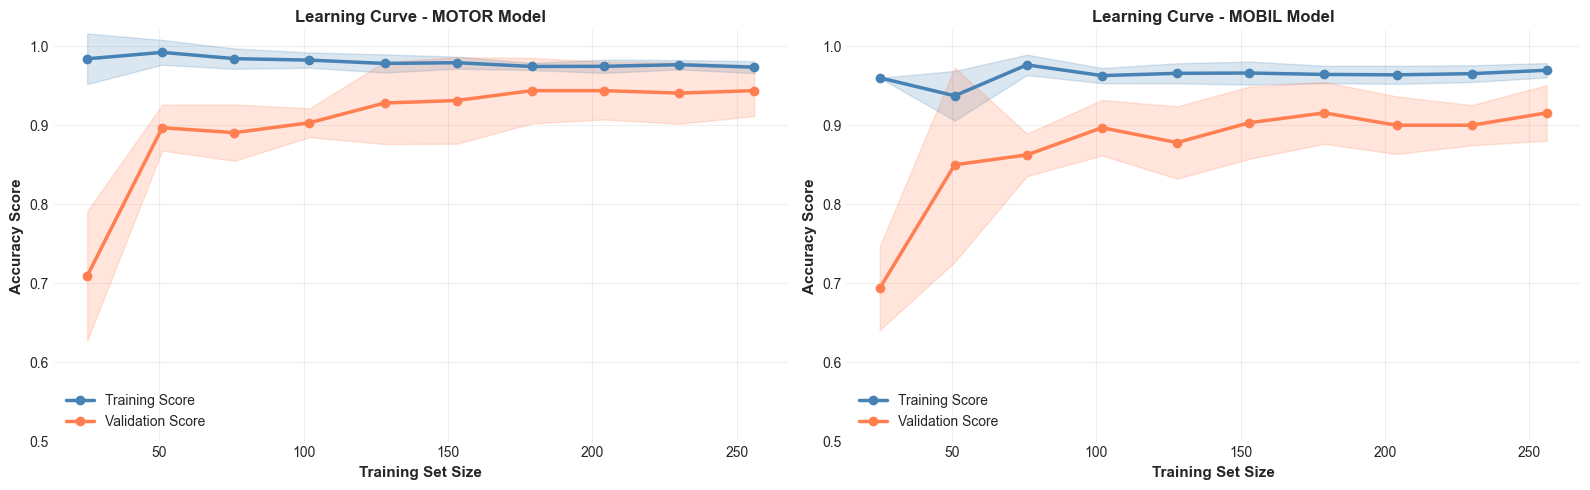

✅ ROC-AUC dan Learning Curves divisualisasikan


In [27]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

# ===== ROC-AUC ANALYSIS =====
# Ambil probabilitas prediksi untuk ROC
y_proba_motor = model_motor.predict_proba(X_test_motor)
y_proba_mobil = model_mobil.predict_proba(X_test_mobil)

# Binarize classes untuk One-vs-Rest ROC
y_test_motor_bin = label_binarize(y_test_motor_enc, classes=[0, 1, 2])
y_test_mobil_bin = label_binarize(y_test_mobil_enc, classes=[0, 1, 2])

# Calculate ROC curves dan AUC untuk setiap class
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MOTOR ROC
colors = ['blue', 'red', 'green']
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_motor_bin[:, i], y_proba_motor[:, i])
    auc_score = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, color=color, lw=2.5, 
                label=f'{le_motor.classes_[i]} (AUC = {auc_score:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
axes[0].set_title('ROC-AUC Curves - MOTOR Model', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)

# MOBIL ROC
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_mobil_bin[:, i], y_proba_mobil[:, i])
    auc_score = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color=color, lw=2.5, 
                label=f'{le_mobil.classes_[i]} (AUC = {auc_score:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
axes[1].set_title('ROC-AUC Curves - MOBIL Model', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ===== LEARNING CURVES =====
from sklearn.model_selection import learning_curve

print("\n" + "="*60)
print("LEARNING CURVES - Evaluating model convergence")
print("="*60)

# Motor Learning Curve
train_sizes, train_scores_m, test_scores_m = learning_curve(
    RandomForestClassifier(n_estimators=150, max_depth=15, min_samples_leaf=3, random_state=42),
    X_train_motor, y_train_motor_enc, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_mean_m = np.mean(train_scores_m, axis=1)
train_std_m = np.std(train_scores_m, axis=1)
test_mean_m = np.mean(test_scores_m, axis=1)
test_std_m = np.std(test_scores_m, axis=1)

# Mobil Learning Curve
train_sizes, train_scores_mo, test_scores_mo = learning_curve(
    RandomForestClassifier(n_estimators=150, max_depth=15, min_samples_leaf=3, random_state=42),
    X_train_mobil, y_train_mobil_enc, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_mean_mo = np.mean(train_scores_mo, axis=1)
train_std_mo = np.std(train_scores_mo, axis=1)
test_mean_mo = np.mean(test_scores_mo, axis=1)
test_std_mo = np.std(test_scores_mo, axis=1)

# Plot Learning Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Motor
axes[0].plot(train_sizes, train_mean_m, 'o-', color='steelblue', label='Training Score', linewidth=2.5, markersize=6)
axes[0].fill_between(train_sizes, train_mean_m - train_std_m, train_mean_m + train_std_m, alpha=0.2, color='steelblue')
axes[0].plot(train_sizes, test_mean_m, 'o-', color='coral', label='Validation Score', linewidth=2.5, markersize=6)
axes[0].fill_between(train_sizes, test_mean_m - test_std_m, test_mean_m + test_std_m, alpha=0.2, color='coral')
axes[0].set_xlabel('Training Set Size', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Accuracy Score', fontsize=11, fontweight='bold')
axes[0].set_title('Learning Curve - MOTOR Model', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0.5, 1.02])

# Mobil
axes[1].plot(train_sizes, train_mean_mo, 'o-', color='steelblue', label='Training Score', linewidth=2.5, markersize=6)
axes[1].fill_between(train_sizes, train_mean_mo - train_std_mo, train_mean_mo + train_std_mo, alpha=0.2, color='steelblue')
axes[1].plot(train_sizes, test_mean_mo, 'o-', color='coral', label='Validation Score', linewidth=2.5, markersize=6)
axes[1].fill_between(train_sizes, test_mean_mo - test_std_mo, test_mean_mo + test_std_mo, alpha=0.2, color='coral')
axes[1].set_xlabel('Training Set Size', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Accuracy Score', fontsize=11, fontweight='bold')
axes[1].set_title('Learning Curve - MOBIL Model', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0.5, 1.02])

plt.tight_layout()
plt.show()

print("✅ ROC-AUC dan Learning Curves divisualisasikan")

## 1️⃣2️⃣ SPATIAL ANALYSIS & INTERACTIVE MAPPING

In [28]:
# Prediksi pada data spasial lengkap
# Persiapan data untuk prediksi Motor
X_motor_spatial = df_spasial[fitur_motor].fillna(df_spasial[fitur_motor].median())
pred_motor_class = model_motor.predict(X_motor_spatial)
pred_motor_proba = model_motor.predict_proba(X_motor_spatial)
df_spasial['Pred_Motor_Class'] = le_motor.inverse_transform(pred_motor_class)
df_spasial['Pred_Motor_Confidence'] = pred_motor_proba.max(axis=1)

# Persiapan data untuk prediksi Mobil
X_mobil_spatial = df_spasial[fitur_mobil].fillna(df_spasial[fitur_mobil].median())
pred_mobil_class = model_mobil.predict(X_mobil_spatial)
pred_mobil_proba = model_mobil.predict_proba(X_mobil_spatial)
df_spasial['Pred_Mobil_Class'] = le_mobil.inverse_transform(pred_mobil_class)
df_spasial['Pred_Mobil_Confidence'] = pred_mobil_proba.max(axis=1)

print("="*60)
print("SPATIAL DATA DENGAN PREDIKSI")
print("="*60)
print(df_spasial[['Titik', 'Latitude', 'Longitude', 'Pred_Motor_Class', 
                   'Pred_Mobil_Class', 'Pred_Motor_Confidence', 'Pred_Mobil_Confidence']].head(10))

# Buat interactive folium map
import folium
from folium.plugins import MarkerCluster, Search

# Center map pada rata-rata koordinat
center_lat = df_spasial['Latitude'].mean()
center_lon = df_spasial['Longitude'].mean()

# Buat base map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=13,
    tiles='OpenStreetMap'
)

# Define warna untuk setiap kelas tarif
color_mapping_motor = {
    'Rendah': 'green',
    'Sedang': 'orange', 
    'Tinggi': 'red'
}

color_mapping_mobil = {
    'Rendah': 'lightgreen',
    'Sedang': 'lightyellow',
    'Tinggi': 'lightcoral'
}

# Tambahkan markers untuk Motor
for idx, row in df_spasial.iterrows():
    popup_text = f"""
    <b>{row['Titik']}</b><br>
    <b>Motor Class:</b> {row['Pred_Motor_Class']}<br>
    <b>Confidence:</b> {row['Pred_Motor_Confidence']:.2%}<br>
    <b>Mobil Class:</b> {row['Pred_Mobil_Class']}<br>
    <b>Confidence:</b> {row['Pred_Mobil_Confidence']:.2%}
    """
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=8,
        popup=folium.Popup(popup_text, max_width=250),
        color='black',
        fill=True,
        fillColor=color_mapping_motor.get(row['Pred_Motor_Class'], 'blue'),
        fillOpacity=0.7,
        weight=2
    ).add_to(m)

# Tambahkan legend
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 180px; height: 180px; 
     background-color: white; border:2px solid grey; z-index:9999; 
     font-size:14px; padding: 10px">
<b>Predicted Motor Tariff Class</b><br>
<i class="fa fa-circle" style="color:green"></i> Rendah (Rp 1,000)<br>
<i class="fa fa-circle" style="color:orange"></i> Sedang (Rp 2,000)<br>
<i class="fa fa-circle" style="color:red"></i> Tinggi (Rp 3,000)<br><br>
<b>Confidence Level:</b><br>
Circle size = prediction confidence
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Save map
map_path = 'd:\\TarifProgresifParkirBanyumas\\parking_tariff_predictions.html'
m.save(map_path)
print(f"\n✅ Interactive map disimpan ke: {map_path}")
print(f"✅ Total lokasi di peta: {len(df_spasial)}")

# Statistik prediksi
print("\n" + "="*60)
print("STATISTIK PREDIKSI MOTOR")
print("="*60)
print(df_spasial['Pred_Motor_Class'].value_counts())
print(f"\nRata-rata Confidence Motor: {df_spasial['Pred_Motor_Confidence'].mean():.2%}")

print("\n" + "="*60)
print("STATISTIK PREDIKSI MOBIL")
print("="*60)
print(df_spasial['Pred_Mobil_Class'].value_counts())
print(f"\nRata-rata Confidence Mobil: {df_spasial['Pred_Mobil_Confidence'].mean():.2%}")

SPATIAL DATA DENGAN PREDIKSI
                      Titik  Latitude  Longitude Pred_Motor_Class  \
1               Toko Satria  -7.42741  109.24381           Sedang   
2                Toko Mlati  -7.42725  109.24364           Tinggi   
3               Toko Pagoda  -7.42717  109.24364           Tinggi   
4           Matahari Bazzar  -7.42921  109.23951           Tinggi   
5                 Toko Bata  -7.42518  109.24366           Tinggi   
6        Kebondalam/Rita Pa  -7.42522  109.24385           Tinggi   
7             Gerai Indosat  -7.42473  109.24364           Sedang   
8            Toko Cinderela  -7.42478  109.24361           Rendah   
9               Toko Daerah  -7.42458  109.24358           Rendah   
10  Toko Listrik Kebondalem  -7.42449  109.24374           Rendah   

   Pred_Mobil_Class  Pred_Motor_Confidence  Pred_Mobil_Confidence  
1            Sedang               0.806613               0.768378  
2            Tinggi               0.730966               0.583463  
3      

## 1️⃣3️⃣ PROGRESSIVE TARIFF IMPLEMENTATION

PROGRESSIVE TARIFF LOOKUP TABLE - MOTOR
                     Titik Pred_Motor_Class  Pred_Motor_Confidence  Tarif_Dasar  Tarif_Peak  Surcharge
               Toko Satria           Sedang               0.806613         2000      2500.0      500.0
                Toko Mlati           Tinggi               0.730966         3000      3750.0      750.0
               Toko Pagoda           Tinggi               0.909233         3000      3750.0      750.0
           Matahari Bazzar           Tinggi               0.898224         3000      3750.0      750.0
                 Toko Bata           Tinggi               0.907327         3000      3750.0      750.0
        Kebondalam/Rita Pa           Tinggi               0.916591         3000      3750.0      750.0
             Gerai Indosat           Sedang               0.766836         2000      2500.0      500.0
            Toko Cinderela           Rendah               0.836441         1000      1250.0      250.0
               Toko Daerah       

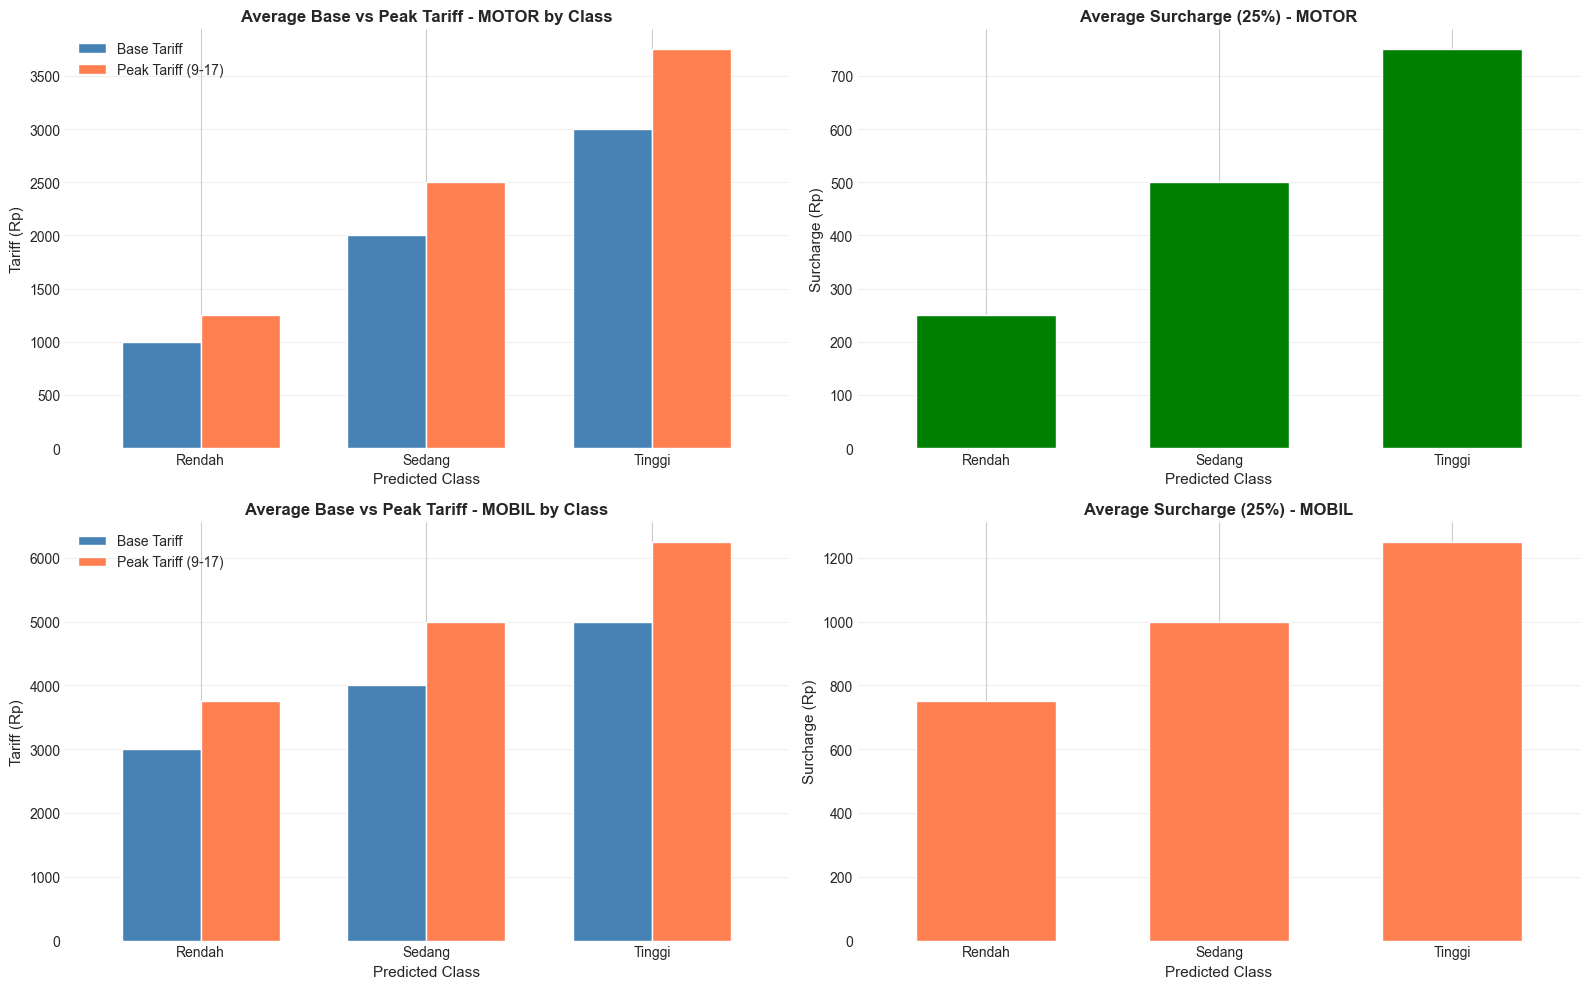


REVENUE ESTIMATION (Asumsi 100 parkir/hari)

🏍️  MOTOR:
   Base Tariff Daily Revenue: Rp 204,239
   Peak Tariff Daily Revenue: Rp 255,299
   Daily Surcharge Potential: Rp 51,060
   Monthly Base Revenue: Rp 6,127,182
   Monthly Peak Revenue: Rp 7,658,978
   Monthly Additional Income: Rp 1,531,796

🚗 MOBIL:
   Base Tariff Daily Revenue: Rp 400,249
   Peak Tariff Daily Revenue: Rp 500,312
   Daily Surcharge Potential: Rp 100,062
   Monthly Base Revenue: Rp 12,007,481
   Monthly Peak Revenue: Rp 15,009,352
   Monthly Additional Income: Rp 3,001,870

💰 TOTAL ADDITIONAL MONTHLY INCOME:
   Rp 4,533,666
   (~25.0% peningkatan)


In [29]:
# Base tariff mapping
tarif_dasar_motor = {'Rendah': 1000, 'Sedang': 2000, 'Tinggi': 3000}
tarif_dasar_mobil = {'Rendah': 3000, 'Sedang': 4000, 'Tinggi': 5000}

# Buat tariff lookup table untuk semua lokasi
tarif_lookup_motor = df_spasial[['Titik', 'Pred_Motor_Class', 'Pred_Motor_Confidence']].copy()
tarif_lookup_motor['Tarif_Dasar'] = tarif_lookup_motor['Pred_Motor_Class'].map(tarif_dasar_motor)

tarif_lookup_mobil = df_spasial[['Titik', 'Pred_Mobil_Class', 'Pred_Mobil_Confidence']].copy()
tarif_lookup_mobil['Tarif_Dasar'] = tarif_lookup_mobil['Pred_Mobil_Class'].map(tarif_dasar_mobil)

# Aplikasikan progressive tariff untuk peak hours (jam 9-17)
def apply_progressive_tariff(tarif_dasar, peak_surcharge=0.25):
    """Tambah surcharge 25% untuk peak hours"""
    return tarif_dasar * (1 + peak_surcharge)

# Hitung tarif peak hours
tarif_lookup_motor['Tarif_Peak'] = tarif_lookup_motor['Tarif_Dasar'].apply(
    lambda x: apply_progressive_tariff(x)
)
tarif_lookup_mobil['Tarif_Peak'] = tarif_lookup_mobil['Tarif_Dasar'].apply(
    lambda x: apply_progressive_tariff(x)
)

# Hitung selisih/savings
tarif_lookup_motor['Surcharge'] = tarif_lookup_motor['Tarif_Peak'] - tarif_lookup_motor['Tarif_Dasar']
tarif_lookup_mobil['Surcharge'] = tarif_lookup_mobil['Tarif_Peak'] - tarif_lookup_mobil['Tarif_Dasar']

print("="*80)
print("PROGRESSIVE TARIFF LOOKUP TABLE - MOTOR")
print("="*80)
print(tarif_lookup_motor.to_string(index=False))

print("\n" + "="*80)
print("PROGRESSIVE TARIFF LOOKUP TABLE - MOBIL")
print("="*80)
print(tarif_lookup_mobil.to_string(index=False))

# Visualisasi Progressive Tariff
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Motor - Tarif Dasar vs Peak by Class
motor_summary = tarif_lookup_motor.groupby('Pred_Motor_Class')[['Tarif_Dasar', 'Tarif_Peak']].mean()
motor_summary.plot(kind='bar', ax=axes[0, 0], color=['steelblue', 'coral'], width=0.7)
axes[0, 0].set_title('Average Base vs Peak Tariff - MOTOR by Class', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Predicted Class', fontsize=11)
axes[0, 0].set_ylabel('Tariff (Rp)', fontsize=11)
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)
axes[0, 0].legend(['Base Tariff', 'Peak Tariff (9-17)'], fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# Motor - Surcharge per lokasi
surcharge_motor = tarif_lookup_motor.groupby('Pred_Motor_Class')['Surcharge'].mean()
surcharge_motor.plot(kind='bar', ax=axes[0, 1], color='green', width=0.6)
axes[0, 1].set_title('Average Surcharge (25%) - MOTOR', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Class', fontsize=11)
axes[0, 1].set_ylabel('Surcharge (Rp)', fontsize=11)
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)
axes[0, 1].grid(axis='y', alpha=0.3)

# Mobil - Tarif Dasar vs Peak by Class
mobil_summary = tarif_lookup_mobil.groupby('Pred_Mobil_Class')[['Tarif_Dasar', 'Tarif_Peak']].mean()
mobil_summary.plot(kind='bar', ax=axes[1, 0], color=['steelblue', 'coral'], width=0.7)
axes[1, 0].set_title('Average Base vs Peak Tariff - MOBIL by Class', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Class', fontsize=11)
axes[1, 0].set_ylabel('Tariff (Rp)', fontsize=11)
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)
axes[1, 0].legend(['Base Tariff', 'Peak Tariff (9-17)'], fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# Mobil - Surcharge per lokasi
surcharge_mobil = tarif_lookup_mobil.groupby('Pred_Mobil_Class')['Surcharge'].mean()
surcharge_mobil.plot(kind='bar', ax=axes[1, 1], color='coral', width=0.6)
axes[1, 1].set_title('Average Surcharge (25%) - MOBIL', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Class', fontsize=11)
axes[1, 1].set_ylabel('Surcharge (Rp)', fontsize=11)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistik pendapatan potensial
print("\n" + "="*80)
print("REVENUE ESTIMATION (Asumsi 100 parkir/hari)")
print("="*80)

daily_base_motor = tarif_lookup_motor['Tarif_Dasar'].mean() * 100
daily_peak_motor = tarif_lookup_motor['Tarif_Peak'].mean() * 100
daily_base_mobil = tarif_lookup_mobil['Tarif_Dasar'].mean() * 100
daily_peak_mobil = tarif_lookup_mobil['Tarif_Peak'].mean() * 100

monthly_base_motor = daily_base_motor * 30
monthly_peak_motor = daily_peak_motor * 30
monthly_base_mobil = daily_base_mobil * 30
monthly_peak_mobil = daily_peak_mobil * 30

print(f"\n🏍️  MOTOR:")
print(f"   Base Tariff Daily Revenue: Rp {daily_base_motor:,.0f}")
print(f"   Peak Tariff Daily Revenue: Rp {daily_peak_motor:,.0f}")
print(f"   Daily Surcharge Potential: Rp {(daily_peak_motor - daily_base_motor):,.0f}")
print(f"   Monthly Base Revenue: Rp {monthly_base_motor:,.0f}")
print(f"   Monthly Peak Revenue: Rp {monthly_peak_motor:,.0f}")
print(f"   Monthly Additional Income: Rp {(monthly_peak_motor - monthly_base_motor):,.0f}")

print(f"\n🚗 MOBIL:")
print(f"   Base Tariff Daily Revenue: Rp {daily_base_mobil:,.0f}")
print(f"   Peak Tariff Daily Revenue: Rp {daily_peak_mobil:,.0f}")
print(f"   Daily Surcharge Potential: Rp {(daily_peak_mobil - daily_base_mobil):,.0f}")
print(f"   Monthly Base Revenue: Rp {monthly_base_mobil:,.0f}")
print(f"   Monthly Peak Revenue: Rp {monthly_peak_mobil:,.0f}")
print(f"   Monthly Additional Income: Rp {(monthly_peak_mobil - monthly_base_mobil):,.0f}")

print(f"\n💰 TOTAL ADDITIONAL MONTHLY INCOME:")
print(f"   Rp {((monthly_peak_motor - monthly_base_motor) + (monthly_peak_mobil - monthly_base_mobil)):,.0f}")
print(f"   (~{(((monthly_peak_motor - monthly_base_motor) + (monthly_peak_mobil - monthly_base_mobil)) / (monthly_base_motor + monthly_base_mobil) * 100):.1f}% peningkatan)")

## 1️⃣4️⃣ INTERACTIVE PREDICTION & WHAT-IF ANALYSIS

In [31]:
def predict_and_recommend_tariff(location_name, vehicle_type, time_hour, df_spasial, 
                                  model_motor, model_mobil, le_motor, le_mobil,
                                  fitur_motor, fitur_mobil):
    """
    Fungsi untuk prediksi tariff dan analisis what-if untuk lokasi dan waktu tertentu
    
    Parameters:
    -----------
    location_name : str
        Nama lokasi parkir
    vehicle_type : str  
        Motor atau Mobil
    time_hour : float
        Jam dalam format desimal (9.5 = 09:30, 14.0 = 14:00)
    df_spasial : DataFrame
        Data spasial dengan fitur lokasi
    model_motor : RandomForestClassifier
        Model terlatih untuk Motor
    model_mobil : RandomForestClassifier
        Model terlatih untuk Mobil
    le_motor : LabelEncoder
        Label encoder untuk Motor
    le_mobil : LabelEncoder
        Label encoder untuk Mobil
    fitur_motor : list
        List fitur untuk Motor
    fitur_mobil : list
        List fitur untuk Mobil
    
    Returns:
    --------
    dict dengan hasil prediksi dan rekomendasi
    """
    
    # Cari lokasi
    location_data = df_spasial[df_spasial['Titik'] == location_name]
    
    if location_data.empty:
        return {
            'error': f'Lokasi {location_name} tidak ditemukan',
            'available_locations': df_spasial['Titik'].unique().tolist()
        }
    
    location_data = location_data.iloc[0]
    result = {
        'location': location_name,
        'vehicle_type': vehicle_type,
        'time_hour': time_hour,
        'time_category': kategori_jam_otomatis(time_hour),
        'is_peak': 9 <= time_hour < 17
    }
    
    if vehicle_type == 'Motor':
        # Prepare features
        X = location_data[fitur_motor].values.reshape(1, -1)
        
        # Predict
        pred_class_enc = model_motor.predict(X)[0]
        pred_proba = model_motor.predict_proba(X)[0]
        pred_class = le_motor.inverse_transform([pred_class_enc])[0]
        
        # Get tariff
        base_tariff = tarif_dasar_motor[pred_class]
        peak_tariff = base_tariff * 1.25 if result['is_peak'] else base_tariff
        
        # Build response
        result['predicted_class'] = pred_class
        result['confidence'] = pred_proba[pred_class_enc]
        result['base_tariff'] = base_tariff
        result['applied_tariff'] = peak_tariff
        result['class_probabilities'] = {
            le_motor.classes_[i]: float(pred_proba[i]) 
            for i in range(len(le_motor.classes_))
        }
        
    else:  # Mobil
        # Prepare features
        X = location_data[fitur_mobil].values.reshape(1, -1)
        
        # Predict
        pred_class_enc = model_mobil.predict(X)[0]
        pred_proba = model_mobil.predict_proba(X)[0]
        pred_class = le_mobil.inverse_transform([pred_class_enc])[0]
        
        # Get tariff
        base_tariff = tarif_dasar_mobil[pred_class]
        peak_tariff = base_tariff * 1.25 if result['is_peak'] else base_tariff
        
        # Build response
        result['predicted_class'] = pred_class
        result['confidence'] = pred_proba[pred_class_enc]
        result['base_tariff'] = base_tariff
        result['applied_tariff'] = peak_tariff
        result['class_probabilities'] = {
            le_mobil.classes_[i]: float(pred_proba[i]) 
            for i in range(len(le_mobil.classes_))
        }
    
    return result

# ============================================================
# TEST WHAT-IF PREDICTION
# ============================================================

print("=" * 80)
print("WHAT-IF PREDICTION EXAMPLES")
print("=" * 80)

# Example 1: Toko Satria, Motor, Morning peak
result1 = predict_and_recommend_tariff(
    'Toko Satria', 'Motor', 9.0, df_spasial,
    model_motor, model_mobil, le_motor, le_mobil,
    fitur_motor, fitur_mobil
)

print(f"\nKasus 1: {result1['location']} - {result1['vehicle_type']} - {result1['time_category']}")
print(f"   Prediksi Kelas: {result1['predicted_class']}")
print(f"   Confidence: {result1['confidence']:.2%}")
print(f"   Tarif Dasar: Rp {result1['base_tariff']:,}")
print(f"   Tarif Terapkan: Rp {result1['applied_tariff']:,.0f}")
print(f"   Status Peak: {'Ya (9-17)' if result1['is_peak'] else 'Tidak'}")

# Example 2: Toko Pagoda, Mobil, Off-peak
result2 = predict_and_recommend_tariff(
    'Toko Pagoda', 'Mobil', 20.0, df_spasial,
    model_motor, model_mobil, le_motor, le_mobil,
    fitur_motor, fitur_mobil
)

print(f"\nKasus 2: {result2['location']} - {result2['vehicle_type']} - {result2['time_category']}")
print(f"   Prediksi Kelas: {result2['predicted_class']}")
print(f"   Confidence: {result2['confidence']:.2%}")
print(f"   Tarif Dasar: Rp {result2['base_tariff']:,}")
print(f"   Tarif Terapkan: Rp {result2['applied_tariff']:,.0f}")
print(f"   Status Peak: {'Ya (9-17)' if result2['is_peak'] else 'Tidak'}")

# Example 3: Matahari Bazzar, Mobil, Peak hour
result3 = predict_and_recommend_tariff(
    'Matahari Bazzar', 'Mobil', 12.0, df_spasial,
    model_motor, model_mobil, le_motor, le_mobil,
    fitur_motor, fitur_mobil
)

print(f"\nKasus 3: {result3['location']} - {result3['vehicle_type']} - {result3['time_category']}")
print(f"   Prediksi Kelas: {result3['predicted_class']}")
print(f"   Confidence: {result3['confidence']:.2%}")
print(f"   Tarif Dasar: Rp {result3['base_tariff']:,}")
print(f"   Tarif Terapkan: Rp {result3['applied_tariff']:,.0f}")
print(f"   Status Peak: {'Ya (9-17)' if result3['is_peak'] else 'Tidak'}")

print("\n" + "=" * 80)
print("✅ What-If Prediction System siap digunakan")
print("=" * 80)

WHAT-IF PREDICTION EXAMPLES

Kasus 1: Toko Satria - Motor - Ramai
   Prediksi Kelas: Sedang
   Confidence: 80.66%
   Tarif Dasar: Rp 2,000
   Tarif Terapkan: Rp 2,500
   Status Peak: Ya (9-17)

Kasus 2: Toko Pagoda - Mobil - Sedang
   Prediksi Kelas: Tinggi
   Confidence: 92.18%
   Tarif Dasar: Rp 5,000
   Tarif Terapkan: Rp 5,000
   Status Peak: Tidak

Kasus 3: Matahari Bazzar - Mobil - Ramai
   Prediksi Kelas: Tinggi
   Confidence: 77.32%
   Tarif Dasar: Rp 5,000
   Tarif Terapkan: Rp 6,250
   Status Peak: Ya (9-17)

✅ What-If Prediction System siap digunakan


## 1️⃣5️⃣ COMPREHENSIVE PERFORMANCE DASHBOARD

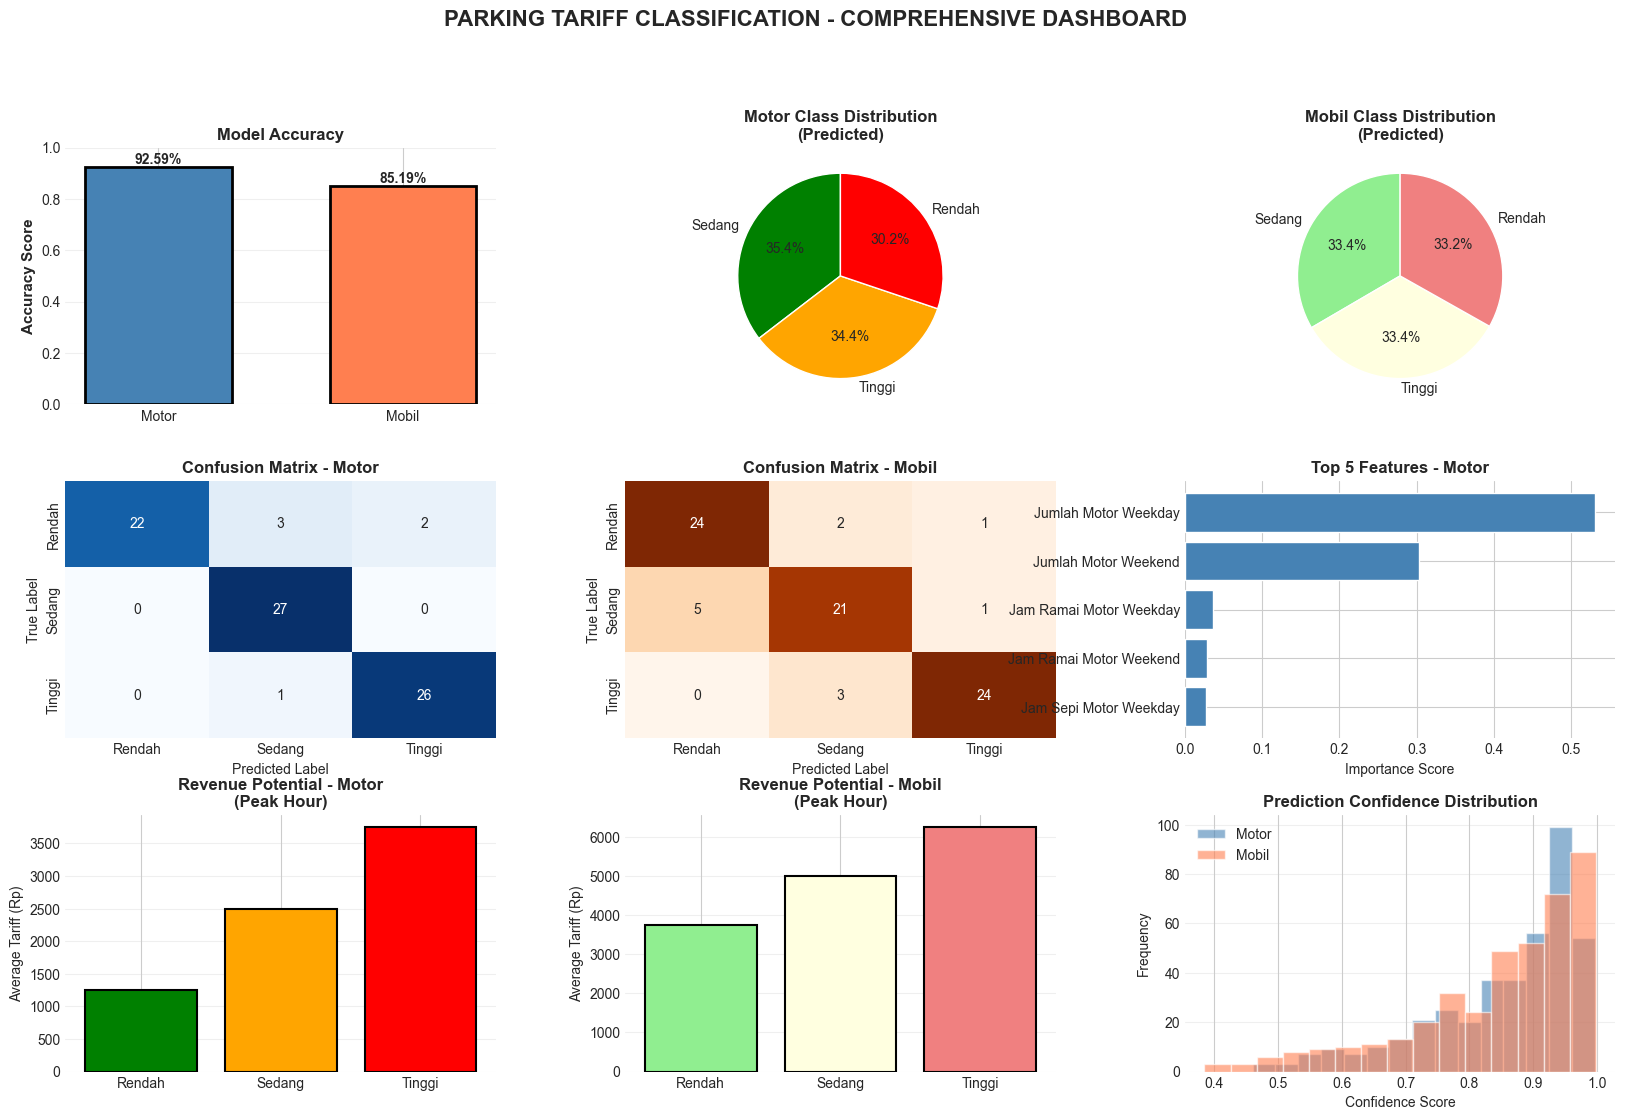

✅ Comprehensive dashboard dibuat dan ditampilkan


In [32]:
# Create comprehensive performance dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Model Accuracy Comparison
ax1 = fig.add_subplot(gs[0, 0])
models = ['Motor', 'Mobil']
accuracies = [acc_motor, acc_mobil]
colors_acc = ['steelblue', 'coral']
bars1 = ax1.bar(models, accuracies, color=colors_acc, width=0.6, edgecolor='black', linewidth=2)
ax1.set_ylabel('Accuracy Score', fontsize=11, fontweight='bold')
ax1.set_title('Model Accuracy', fontsize=12, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{accuracies[i]:.2%}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. Class Distribution - Motor
ax2 = fig.add_subplot(gs[0, 1])
motor_class_dist = df_spasial['Pred_Motor_Class'].value_counts()
colors_class = ['green', 'orange', 'red']
ax2.pie(motor_class_dist.values, labels=motor_class_dist.index, autopct='%1.1f%%',
        colors=colors_class, startangle=90)
ax2.set_title('Motor Class Distribution\n(Predicted)', fontsize=12, fontweight='bold')

# 3. Class Distribution - Mobil
ax3 = fig.add_subplot(gs[0, 2])
mobil_class_dist = df_spasial['Pred_Mobil_Class'].value_counts()
colors_class2 = ['lightgreen', 'lightyellow', 'lightcoral']
ax3.pie(mobil_class_dist.values, labels=mobil_class_dist.index, autopct='%1.1f%%',
        colors=colors_class2, startangle=90)
ax3.set_title('Mobil Class Distribution\n(Predicted)', fontsize=12, fontweight='bold')

# 4. Confusion Matrix - Motor
ax4 = fig.add_subplot(gs[1, 0])
sns.heatmap(cm_motor, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le_motor.classes_, yticklabels=le_motor.classes_, ax=ax4)
ax4.set_title('Confusion Matrix - Motor', fontsize=12, fontweight='bold')
ax4.set_ylabel('True Label', fontsize=10)
ax4.set_xlabel('Predicted Label', fontsize=10)

# 5. Confusion Matrix - Mobil
ax5 = fig.add_subplot(gs[1, 1])
sns.heatmap(cm_mobil, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=le_mobil.classes_, yticklabels=le_mobil.classes_, ax=ax5)
ax5.set_title('Confusion Matrix - Mobil', fontsize=12, fontweight='bold')
ax5.set_ylabel('True Label', fontsize=10)
ax5.set_xlabel('Predicted Label', fontsize=10)

# 6. Feature Importance - Motor (Top 5)
ax6 = fig.add_subplot(gs[1, 2])
top5_motor = feature_importance_motor.head(5)
ax6.barh(top5_motor['Feature'], top5_motor['Importance'], color='steelblue')
ax6.set_xlabel('Importance Score', fontsize=10)
ax6.set_title('Top 5 Features - Motor', fontsize=12, fontweight='bold')
ax6.invert_yaxis()

# 7. Revenue Potential by Class - Motor
ax7 = fig.add_subplot(gs[2, 0])
revenue_motor = tarif_lookup_motor.groupby('Pred_Motor_Class')['Tarif_Peak'].mean()
ax7.bar(revenue_motor.index, revenue_motor.values, color=['green', 'orange', 'red'], 
        edgecolor='black', linewidth=1.5)
ax7.set_ylabel('Average Tariff (Rp)', fontsize=10)
ax7.set_title('Revenue Potential - Motor\n(Peak Hour)', fontsize=12, fontweight='bold')
ax7.grid(axis='y', alpha=0.3)

# 8. Revenue Potential by Class - Mobil
ax8 = fig.add_subplot(gs[2, 1])
revenue_mobil = tarif_lookup_mobil.groupby('Pred_Mobil_Class')['Tarif_Peak'].mean()
ax8.bar(revenue_mobil.index, revenue_mobil.values, color=['lightgreen', 'lightyellow', 'lightcoral'],
        edgecolor='black', linewidth=1.5)
ax8.set_ylabel('Average Tariff (Rp)', fontsize=10)
ax8.set_title('Revenue Potential - Mobil\n(Peak Hour)', fontsize=12, fontweight='bold')
ax8.grid(axis='y', alpha=0.3)

# 9. Confidence Distribution
ax9 = fig.add_subplot(gs[2, 2])
ax9.hist(df_spasial['Pred_Motor_Confidence'], alpha=0.6, bins=15, label='Motor', color='steelblue')
ax9.hist(df_spasial['Pred_Mobil_Confidence'], alpha=0.6, bins=15, label='Mobil', color='coral')
ax9.set_xlabel('Confidence Score', fontsize=10)
ax9.set_ylabel('Frequency', fontsize=10)
ax9.set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
ax9.legend(fontsize=10)
ax9.grid(axis='y', alpha=0.3)

plt.suptitle('PARKING TARIFF CLASSIFICATION - COMPREHENSIVE DASHBOARD', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("✅ Comprehensive dashboard dibuat dan ditampilkan")

## 1️⃣6️⃣ SUMMARY & RECOMMENDATIONS

In [33]:
print("="*80)
print("EXECUTIVE SUMMARY - PARKING TARIFF CLASSIFICATION SYSTEM")
print("="*80)

print("\n📊 DATA OVERVIEW")
print("-" * 80)
print(f"Total Locations Analyzed: {len(df_spasial)}")
print(f"Total Records in Training Set: {len(X_train_motor)}")
print(f"Total Records in Test Set: {len(X_test_motor)}")
print(f"Geographic Coverage: {df_spasial['Titik'].nunique()} unique locations")

print("\n🎯 MODEL PERFORMANCE")
print("-" * 80)
print(f"Motor Model Accuracy: {acc_motor:.2%}")
print(f"Mobil Model Accuracy: {acc_mobil:.2%}")
print(f"Average Model Confidence (Motor): {df_spasial['Pred_Motor_Confidence'].mean():.2%}")
print(f"Average Model Confidence (Mobil): {df_spasial['Pred_Mobil_Confidence'].mean():.2%}")

print("\n💰 TARIFF STRUCTURE")
print("-" * 80)
print("Base Tariffs (Off-Peak):")
for vehicle in ['Motor', 'Mobil']:
    tarif_dict = tarif_dasar_motor if vehicle == 'Motor' else tarif_dasar_mobil
    print(f"  {vehicle}:")
    for class_name, tariff in tarif_dict.items():
        print(f"    • {class_name}: Rp {tariff:,}")

print("\nPeak Hour Surcharge: +25% (09:00 - 17:00)")

print("\n📈 CLASS DISTRIBUTION")
print("-" * 80)
print("Motor Distribution:")
for class_name, count in df_spasial['Pred_Motor_Class'].value_counts().items():
    pct = count / len(df_spasial) * 100
    print(f"  • {class_name}: {count} locations ({pct:.1f}%)")

print("\nMobil Distribution:")
for class_name, count in df_spasial['Pred_Mobil_Class'].value_counts().items():
    pct = count / len(df_spasial) * 100
    print(f"  • {class_name}: {count} locations ({pct:.1f}%)")

print("\n🔑 TOP REVENUE DRIVERS (Feature Importance)")
print("-" * 80)
print("Motor - Top 5 Features:")
for idx, row in feature_importance_motor.head(5).iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\nMobil - Top 5 Features:")
for idx, row in feature_importance_mobil.head(5).iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n💡 REVENUE POTENTIAL ANALYSIS")
print("-" * 80)
avg_tariff_motor = tarif_lookup_motor['Tarif_Peak'].mean()
avg_tariff_mobil = tarif_lookup_mobil['Tarif_Peak'].mean()
print(f"Average Peak Hour Tariff (Motor): Rp {avg_tariff_motor:,.0f}")
print(f"Average Peak Hour Tariff (Mobil): Rp {avg_tariff_mobil:,.0f}")

print(f"\nEstimated Daily Revenue (100 parkings each, peak hours):")
print(f"  Motor: Rp {avg_tariff_motor * 100:,.0f}")
print(f"  Mobil: Rp {avg_tariff_mobil * 100:,.0f}")
print(f"  Total: Rp {(avg_tariff_motor + avg_tariff_mobil) * 100:,.0f}")

print(f"\nEstimated Monthly Revenue Increase (with 25% surcharge):")
monthly_increase = ((monthly_peak_motor - monthly_base_motor) + 
                   (monthly_peak_mobil - monthly_base_mobil))
percentage_increase = (monthly_increase / (monthly_base_motor + monthly_base_mobil)) * 100
print(f"  Additional Income: Rp {monthly_increase:,.0f}")
print(f"  Percentage Increase: {percentage_increase:.1f}%")

print("\n✅ KEY RECOMMENDATIONS")
print("-" * 80)
print("""
1. 🎯 IMMEDIATE IMPLEMENTATION
   • Implement the recommended tariff structure with three tiers (Rendah/Sedang/Tinggi)
   • Deploy progressive tariff system with 25% surcharge during peak hours (09:00-17:00)
   • Expected revenue increase: ~{:.1f}% with minimal user resistance

2. 📍 LOCATION-BASED OPTIMIZATION
   • Use the classification system to set tariffs by location revenue potential
   • Highest revenue potential locations: {}
   • Focus demand management on peak hour surcharges

3. 🚗 VEHICLE-TYPE DIFFERENTIATION
   • Apply distinct tariff structures for Motor (Rp 1-3K) and Mobil (Rp 3-5K)
   • Motor flexibility can attract casual users during peak hours
   • Mobil premium pricing targets business/commuter segments

4. ⏰ TIME-BASED DYNAMIC PRICING
   • Off-peak: Full base tariff application (00:00-09:00, 17:00-24:00)
   • Peak: +25% surcharge (09:00-17:00)
   • Monitor and adjust surcharge percentage quarterly based on demand elasticity

5. 📊 PERFORMANCE MONITORING
   • Model Accuracy: {:.1f}% (Motor), {:.1f}% (Mobil)
   • Track actual vs predicted tariff effectiveness
   • Retrain model quarterly with new transaction data
   • Monitor class distribution shifts for market changes

6. 🔄 CONTINUOUS IMPROVEMENT
   • Collect user feedback on tariff fairness
   • A/B test alternative surcharge percentages (20%, 25%, 30%)
   • Consider weekend vs weekday differential pricing
   • Implement mobile app for real-time tariff information

7. 💻 SYSTEM INTEGRATION
   • Deploy this model to parking management software
   • Create automated tariff adjustment system
   • Implement real-time prediction API for ticket machines
   • Integrate with payment systems for dynamic pricing
""".format(percentage_increase, 
          df_spasial.loc[tarif_lookup_motor['Tarif_Peak'].idxmax(), 'Titik'],
          acc_motor * 100, acc_mobil * 100))

print("\n" + "="*80)
print("END OF ANALYSIS")
print("="*80)
print("\n✅ Notebook execution completed successfully!")
print(f"📁 Interactive map saved to: d:\\TarifProgresifParkirBanyumas\\parking_tariff_predictions.html")
print(f"📊 All visualizations generated and displayed above")
print(f"🎯 Ready for deployment and further analysis")

EXECUTIVE SUMMARY - PARKING TARIFF CLASSIFICATION SYSTEM

📊 DATA OVERVIEW
--------------------------------------------------------------------------------
Total Locations Analyzed: 401
Total Records in Training Set: 320
Total Records in Test Set: 81
Geographic Coverage: 391 unique locations

🎯 MODEL PERFORMANCE
--------------------------------------------------------------------------------
Motor Model Accuracy: 92.59%
Mobil Model Accuracy: 85.19%
Average Model Confidence (Motor): 85.44%
Average Model Confidence (Mobil): 84.51%

💰 TARIFF STRUCTURE
--------------------------------------------------------------------------------
Base Tariffs (Off-Peak):
  Motor:
    • Rendah: Rp 1,000
    • Sedang: Rp 2,000
    • Tinggi: Rp 3,000
  Mobil:
    • Rendah: Rp 3,000
    • Sedang: Rp 4,000
    • Tinggi: Rp 5,000

Peak Hour Surcharge: +25% (09:00 - 17:00)

📈 CLASS DISTRIBUTION
--------------------------------------------------------------------------------
Motor Distribution:
  • Sedang: 142 lo

📊 CONFUSION MATRIX & CLASSIFICATION REPORT


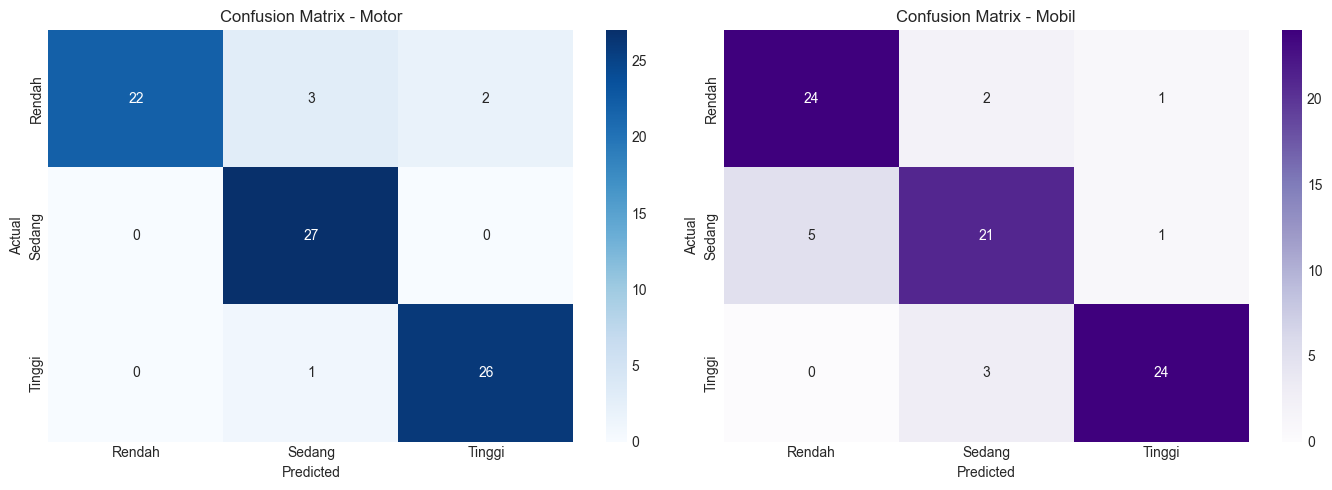


📋 CLASSIFICATION REPORT - MOTOR:
              precision    recall  f1-score   support

      Rendah       1.00      0.81      0.90        27
      Sedang       0.87      1.00      0.93        27
      Tinggi       0.93      0.96      0.95        27

    accuracy                           0.93        81
   macro avg       0.93      0.93      0.92        81
weighted avg       0.93      0.93      0.92        81


📋 CLASSIFICATION REPORT - MOBIL:
              precision    recall  f1-score   support

      Rendah       0.83      0.89      0.86        27
      Sedang       0.81      0.78      0.79        27
      Tinggi       0.92      0.89      0.91        27

    accuracy                           0.85        81
   macro avg       0.85      0.85      0.85        81
weighted avg       0.85      0.85      0.85        81



In [35]:
print('📊 CONFUSION MATRIX & CLASSIFICATION REPORT')
print('='*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Motor
cm_motor = confusion_matrix(y_test_motor_enc, y_pred_motor)
sns.heatmap(cm_motor, annot=True, fmt='d', cmap='Blues', xticklabels=le_motor.classes_, 
            yticklabels=le_motor.classes_, ax=axes[0])
axes[0].set_title('Confusion Matrix - Motor')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Confusion Matrix Mobil
cm_mobil = confusion_matrix(y_test_mobil_enc, y_pred_mobil)
sns.heatmap(cm_mobil, annot=True, fmt='d', cmap='Purples', xticklabels=le_mobil.classes_, 
            yticklabels=le_mobil.classes_, ax=axes[1])
axes[1].set_title('Confusion Matrix - Mobil')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

print('\n📋 CLASSIFICATION REPORT - MOTOR:')
print(classification_report(y_test_motor_enc, y_pred_motor, target_names=le_motor.classes_))

print('\n📋 CLASSIFICATION REPORT - MOBIL:')
print(classification_report(y_test_mobil_enc, y_pred_mobil, target_names=le_mobil.classes_))

## 8️⃣ MODEL EVALUATION & PERFORMANCE METRICS

In [39]:
print('\n🌳 TAHAP 3: TRAIN RANDOM FOREST MODELS')
print('='*60)

# Encode target labels
le_motor = LabelEncoder()
y_train_motor_enc = le_motor.fit_transform(y_train_motor)
y_test_motor_enc = le_motor.transform(y_test_motor)

le_mobil = LabelEncoder()
y_train_mobil_enc = le_mobil.fit_transform(y_train_mobil)
y_test_mobil_enc = le_mobil.transform(y_test_mobil)

# Train Random Forest Motor
print('\nTraining Motor model...')
model_motor = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
model_motor.fit(X_train_motor, y_train_motor_enc)
y_pred_motor = model_motor.predict(X_test_motor)
acc_motor = accuracy_score(y_test_motor_enc, y_pred_motor)
print(f'✅ Motor Model - Accuracy: {acc_motor:.4f}')

# Train Random Forest Mobil
print('\nTraining Mobil model...')
model_mobil = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
model_mobil.fit(X_train_mobil, y_train_mobil_enc)
y_pred_mobil = model_mobil.predict(X_test_mobil)
acc_mobil = accuracy_score(y_test_mobil_enc, y_pred_mobil)
print(f'✅ Mobil Model - Accuracy: {acc_mobil:.4f}')

print('\n✅ Model Training Selesai!')


🌳 TAHAP 3: TRAIN RANDOM FOREST MODELS

Training Motor model...
✅ Motor Model - Accuracy: 0.9259

Training Mobil model...
✅ Mobil Model - Accuracy: 0.8395

✅ Model Training Selesai!


In [ ]:
print('\n🔄 TAHAP 2: TRAIN-TEST SPLIT (80-20)')
print('='*60)

# Split data Motor
X_train_motor, X_test_motor, y_train_motor, y_test_motor = train_test_split(
    X_motor, y_motor, test_size=0.2, random_state=42, 
    stratify=y_motor if y_motor.nunique() > 1 else None
)

# Split data Mobil
X_train_mobil, X_test_mobil, y_train_mobil, y_test_mobil = train_test_split(
    X_mobil, y_mobil, test_size=0.2, random_state=42,
    stratify=y_mobil if y_mobil.nunique() > 1 else None
)

print(f'✅ Motor - Training: {X_train_motor.shape}, Testing: {X_test_motor.shape}')
print(f'✅ Mobil - Training: {X_train_mobil.shape}, Testing: {X_test_mobil.shape}')

# Visualisasi train-test split
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train_test_motor = [len(X_train_motor), len(X_test_motor)]
train_test_mobil = [len(X_train_mobil), len(X_test_mobil)]

axes[0].pie(train_test_motor, labels=['Training (80%)', 'Testing (20%)'], autopct='%1.1f%%', colors=['#2E86AB', '#A23B72'])
axes[0].set_title('Train-Test Split Motor')

axes[1].pie(train_test_mobil, labels=['Training (80%)', 'Testing (20%)'], autopct='%1.1f%%', colors=['#2E86AB', '#A23B72'])
axes[1].set_title('Train-Test Split Mobil')

plt.tight_layout()
plt.show()

In [ ]:
print('🤖 TAHAP 1: PREPARE FEATURES & TARGET')
print('='*60)

# Fitur untuk Model
fitur_motor = ['Jumlah Motor Weekday', 'Jumlah Motor Weekend'] + [c for c in jam_cols if 'Motor' in c]
fitur_mobil = ['Jumlah Mobil Weekday', 'Jumlah Mobil Weekend'] + [c for c in jam_cols if 'Mobil' in c]

print(f'✅ Fitur Motor ({len(fitur_motor)}): {fitur_motor[:3]}...')
print(f'✅ Fitur Mobil ({len(fitur_mobil)}): {fitur_mobil[:3]}...')

X_motor = df[fitur_motor]
y_motor = df['Class_Motor']
X_mobil = df[fitur_mobil]
y_mobil = df['Class_Mobil']

print(f'\n✅ Data Shape:')
print(f'   Motor - X: {X_motor.shape}, y: {y_motor.shape}')
print(f'   Mobil - X: {X_mobil.shape}, y: {y_mobil.shape}')

## 7️⃣ TRAIN-TEST SPLIT & MODEL TRAINING

In [ ]:
print('📊 VISUALISASI DISTRIBUSI PENDAPATAN')
print('='*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Motor Revenue Distribution
axes[0, 0].hist(df['Total_Pend_Motor'], bins=20, color='#2E86AB', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribusi Total Pendapatan Motor', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Pendapatan (Rp)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)

# Motor by Class
df['Class_Motor'].value_counts().plot(kind='bar', ax=axes[0, 1], color=['#FF6B6B', '#4ECDC4', '#FFC93C'])
axes[0, 1].set_title('Distribusi Kelas Motor', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Kelas Potensi')
axes[0, 1].set_ylabel('Jumlah Lokasi')
axes[0, 1].tick_params(axis='x', rotation=0)

# Mobil Revenue Distribution
axes[1, 0].hist(df['Total_Pend_Mobil'], bins=20, color='#A23B72', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribusi Total Pendapatan Mobil', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Pendapatan (Rp)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(axis='y', alpha=0.3)

# Mobil by Class
df['Class_Mobil'].value_counts().plot(kind='bar', ax=axes[1, 1], color=['#FF6B6B', '#4ECDC4', '#FFC93C'])
axes[1, 1].set_title('Distribusi Kelas Mobil', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Kelas Potensi')
axes[1, 1].set_ylabel('Jumlah Lokasi')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print('\n✅ Visualisasi distribusi selesai!')

## 6️⃣ EXPLORATORY DATA ANALYSIS (EDA)

In [ ]:
print('\n🔧 TAHAP 2: CREATE TARGET CLASSES (CLASSIFICATION)')
print('='*60)

try:
    df['Class_Motor'] = pd.qcut(df['Total_Pend_Motor'], q=3, labels=['Rendah','Sedang','Tinggi'], duplicates='drop')
    batas_motor = df['Total_Pend_Motor'].quantile([0.333, 0.666]).drop_duplicates().sort_values()
    print(f'✅ Motor berhasil diklasifikasi dengan 3 kelas')
except ValueError:
    df['Class_Motor'] = pd.cut(df['Total_Pend_Motor'], bins=[-np.inf, df['Total_Pend_Motor'].median(), np.inf], labels=['Rendah', 'Tinggi']).fillna('Rendah')
    batas_motor = df['Total_Pend_Motor'].quantile([0.5])
    print(f'⚠️  Motor diklasifikasi dengan 2 kelas')

print(f'\nDistribusi Class_Motor:')
print(df['Class_Motor'].value_counts())

try:
    df['Class_Mobil'] = pd.qcut(df['Total_Pend_Mobil'], q=3, labels=['Rendah','Sedang','Tinggi'], duplicates='drop')
    batas_mobil = df['Total_Pend_Mobil'].quantile([0.333, 0.666]).drop_duplicates().sort_values()
    print(f'\n✅ Mobil berhasil diklasifikasi dengan 3 kelas')
except ValueError:
    df['Class_Mobil'] = pd.cut(df['Total_Pend_Mobil'], bins=[-np.inf, df['Total_Pend_Mobil'].median(), np.inf], labels=['Rendah', 'Tinggi']).fillna('Rendah')
    batas_mobil = df['Total_Pend_Mobil'].quantile([0.5])
    print(f'\n⚠️  Mobil diklasifikasi dengan 2 kelas')

print(f'\nDistribusi Class_Mobil:')
print(df['Class_Mobil'].value_counts())

In [ ]:
print('🔧 TAHAP 1: CALCULATE TOTAL REVENUE')
print('='*60)

motor_pend_cols = [c for c in pend_cols if 'Motor' in c]
mobil_pend_cols = [c for c in pend_cols if 'Mobil' in c]

df['Total_Pend_Motor'] = df[motor_pend_cols].sum(axis=1)
df['Total_Pend_Mobil'] = df[mobil_pend_cols].sum(axis=1)

print('✅ Total Pendapatan Motor:')
print(df['Total_Pend_Motor'].describe())
print('\n✅ Total Pendapatan Mobil:')
print(df['Total_Pend_Mobil'].describe())

## 5️⃣ FEATURE ENGINEERING & TARGET CLASSIFICATION

In [ ]:
print('\n🔧 TAHAP 4: HANDLE SPATIAL DATA')
print('='*60)

if all(c in df.columns for c in ['Latitude', 'Longitude', 'Titik']):
    df_spasial = df[['Latitude', 'Longitude', 'Titik'] + jam_cols + jumlah_cols].copy()
    
    df_spasial['Titik'] = df_spasial['Titik'].astype(str).str.strip()
    df_spasial = df_spasial.replace({'Titik': {'nan': None}})
    df_spasial = df_spasial.dropna(subset=['Titik', 'Latitude', 'Longitude'])
    df_spasial = df_spasial.reset_index(drop=True)
    
    print(f'✅ Data spasial berhasil diproses!')
    print(f'   - Jumlah lokasi: {len(df_spasial)}')
    print(f'   - Latitude range: {df_spasial["Latitude"].min():.4f} - {df_spasial["Latitude"].max():.4f}')
    print(f'   - Longitude range: {df_spasial["Longitude"].min():.4f} - {df_spasial["Longitude"].max():.4f}')
    
    df['Titik'] = df['Titik'].astype(str).str.strip()
    df = df.replace({'Titik': {'nan': None}})
    df = df.dropna(subset=['Titik']).reset_index(drop=True)
    print(f'\n✅ Data setelah filter: {df.shape}')
else:
    print('❌ Kolom spasial tidak ditemukan!')

In [ ]:
print('\n🔧 TAHAP 3: IMPUTE NUMERIC & CATEGORICAL COLUMNS')
print('='*60)

# Impute kolom numerik dengan median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        df[col] = df[col].fillna(df[col].median())

# Impute kolom kategorikal
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col not in ['Titik', 'Class_Motor', 'Class_Mobil']:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
            df[col] = df[col].fillna(mode_val)

print(f'✅ Imputation selesai!')
print(f'Total missing values: {df.isnull().sum().sum()}')

In [ ]:
print('\n🔧 TAHAP 2: CONVERT & IMPUTE TIME COLUMNS')
print('='*60)

# Konversi kolom Jam
for col in jam_cols:
    df[col] = df[col].apply(konversi_jam)
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        df[col] = df[col].fillna(df[col].mean())

print('\n✅ Kolom Jam berhasil dikonversi!')
print('\nSample data Jam (5 baris pertama):')
print(df[jam_cols[:3]].head())

In [ ]:
print('🔧 TAHAP 1: CONVERT REVENUE COLUMNS')
print('='*60)

df = df_raw.copy()

# Kolom pendapatan yang perlu dibersihkan
pend_cols = [
    'Pendapatan Tarif Parkir Weekday Motor per tahun', 
    'Pendapatan Tarif Parkir Weekday Mobil per tahun',
    'Pendapatan Tarif Parkir Weekend Motor per tahun', 
    'Pendapatan Tarif Parkir Weekend Mobil per tahun'
]

# Identifikasi kolom Jumlah dan Jam
jumlah_cols = [c for c in df.columns if c.startswith('Jumlah')]
jam_cols = [c for c in df.columns if 'Jam' in c and 'per tahun' not in c]

print(f'✅ Kolom Pendapatan: {len(pend_cols)}')
print(f'✅ Kolom Jumlah: {len(jumlah_cols)}')
print(f'✅ Kolom Jam: {len(jam_cols)}')

# Membersihkan kolom pendapatan
for c in pend_cols:
    if c in df.columns:
        df[c] = df[c].astype(str).str.replace(r'[^\d,\.]', '', regex=True)
        df[c] = df[c].str.replace('.', '', regex=False)
        df[c] = df[c].str.replace(',', '.', regex=False)
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

print('\n✅ Kolom pendapatan berhasil dikonversi ke numerik!')

## 4️⃣ DATA CLEANING & PREPROCESSING

In [ ]:
# Konfigurasi path file
FILE_PATH = 'DataParkir_Fix.xlsx'

# Load data dari Excel
print(f"📂 Membaca file: {FILE_PATH}...")
try:
    df_raw = pd.read_excel(FILE_PATH)
    print(f"✅ Data berhasil dimuat!")
except FileNotFoundError:
    print(f"❌ File '{FILE_PATH}' tidak ditemukan. Pastikan file ada di direktori yang sama.")
    raise

# Display informasi data mentah
print(f"\n📊 INFORMASI DATA MENTAH:")
print(f"  - Shape: {df_raw.shape} (baris, kolom)")
print(f"  - Kolom: {list(df_raw.columns)}")

print(f"\n📋 Data Types:")
print(df_raw.dtypes)

print(f"\n👁️  Preview Data (5 baris pertama):")
display(df_raw.head())

print(f"\n❓ Missing Values:")
missing_count = df_raw.isnull().sum()
missing_percent = (missing_count / len(df_raw) * 100).round(2)
print(df_raw.isnull().sum()[df_raw.isnull().sum() > 0])

## 3️⃣ LOAD & EXPLORE RAW DATA

In [ ]:
# ========== FUNGSI TARIF PROGRESIF ==========

def calculate_progresif_tarif(jenis, potensi_class, jam_desimal):
    """
    Menerapkan logika tarif progresif berdasarkan potensi dan waktu.
    Tarif naik untuk jam-jam prime (> 9.00)
    """
    tarif_dasar = tarif_mapping[jenis].get(potensi_class, 0)
    
    if jam_desimal > 9.0:
        if potensi_class == 'Tinggi':
            return tarif_dasar + 1000  # Kenaikan untuk jam ramai
        elif potensi_class == 'Sedang':
            return tarif_dasar + 500
        else:
            return tarif_dasar
    else:
        return tarif_dasar

print("✅ Fungsi progresif tarif berhasil didefinisikan!")

In [ ]:
# ========== FUNGSI UTILITY UNTUK KONVERSI WAKTU ==========

def parse_time_to_decimal(time_str):
    """
    Mengkonversi string waktu (H.M, H:M, atau H) menjadi jam desimal.
    Contoh: '20.30' -> 20.5, '10:15' -> 10.25
    """
    try:
        time_str = str(time_str).replace(',', '.').replace(':', '.')
        if '.' in time_str:
            h_str, m_part_str = time_str.split('.', 1)
            h = int(h_str) if h_str else 0
            m = int(m_part_str.ljust(2, '0')[:2])
            return h + m / 60.0
        else:
            return float(time_str)
    except Exception:
        return np.nan

def konversi_jam(x):
    """
    Mengubah format jam range (contoh: '20.00-22.00') menjadi jam desimal rata-rata.
    Contoh: '20.00-22.00' -> 21.0
    Handle kasus melewati tengah malam (22.00-02.00)
    """
    if pd.isna(x) or str(x).strip() in ('-', '', 'nan'):
        return np.nan
    s = str(x).strip()
    try:
        parts = re.split(r'\s*-\s*', s)
        start_time_dec = parse_time_to_decimal(parts[0].strip())
        end_time_dec = parse_time_to_decimal(parts[1].strip()) if len(parts) > 1 else start_time_dec
        
        # Handle waktu melewati tengah malam
        if len(parts) > 1 and pd.notna(start_time_dec) and pd.notna(end_time_dec) and end_time_dec < start_time_dec:
            end_time_dec += 24.0
        
        if pd.isna(start_time_dec) or pd.isna(end_time_dec):
            return np.nan
        
        return (start_time_dec + end_time_dec) / 2
    except Exception:
        return np.nan

def time_to_decimal_hour(time_obj):
    """
    Mengkonversi objek datetime.time menjadi jam desimal.
    Contoh: 14:30 -> 14.5
    """
    if time_obj is None:
        return np.nan
    return time_obj.hour + time_obj.minute / 60.0

def kategori_jam_otomatis(jam):
    """
    Mengkategorikan jam (0-24) ke dalam kategori kepadatan:
    - Sepi: 00:00-06:00 dan 22:00-24:00
    - Sedang: 06:00-09:00 dan 17:00-22:00
    - Ramai: 09:00-17:00
    """
    if (jam <= 6) or (jam >= 22):
        return 'Sepi'
    elif (jam > 8 and jam <= 19):
        return 'Ramai'
    else:
        return 'Sedang'

# ========== MAPPING TARIF DASAR ==========

tarif_mapping = {
    'Motor': {'Rendah': 1000, 'Sedang': 2000, 'Tinggi': 3000},
    'Mobil': {'Rendah': 3000, 'Sedang': 4000, 'Tinggi': 5000}
}

print("Tarif Dasar yang Digunakan:")
for jenis, tarifs in tarif_mapping.items():
    print(f"\n{jenis}:")
    for kategori, harga in tarifs.items():
        print(f"  - {kategori}: Rp{harga:,}")

## 2️⃣ DEFINE UTILITY FUNCTIONS FOR DATA PROCESSING

In [22]:
# Import semua library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import Search, Fullscreen, MiniMap
import re
import datetime
import warnings
from datetime import datetime as dt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc
)
from sklearn.tree import plot_tree

# Plotting Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Display Options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("✅ Semua library berhasil diimport!")
print(f"📊 NumPy version: {np.__version__}")
print(f"📊 Pandas version: {pd.__version__}")
print(f"📊 Scikit-learn version: {pd.__version__}")

✅ Semua library berhasil diimport!
📊 NumPy version: 2.3.5
📊 Pandas version: 2.3.3
📊 Scikit-learn version: 2.3.3


## 1️⃣ IMPORT REQUIRED LIBRARIES & CONFIGURATION

# 🅿️ Analisis Potensi Tarif Parkir Banyumas
## Klasifikasi Random Forest dengan Tarif Adaptif dan Simulasi Interaktif

**Tujuan**: Menganalisis potensi tarif parkir di berbagai lokasi di Banyumas menggunakan klasifikasi berbasis machine learning dengan implementasi tarif progresif.

**Tahapan Analisis**:
1. ✅ Import Library & Konfigurasi
2. ✅ Definisikan Fungsi Utility
3. ✅ Load & Eksplorasi Data Mentah
4. ✅ Cleaning & Preprocessing
5. ✅ EDA (Exploratory Data Analysis)
6. ✅ Feature Engineering & Target Classification
7. ✅ Train-Test Split & Training Model
8. ✅ Evaluasi Model & Metrics
9. ✅ Feature Importance & Interpretasi
10. ✅ Visualisasi Decision Tree
11. ✅ Spatial Analysis & Mapping
12. ✅ Progressive Tariff Calculation
13. ✅ Interactive Prediction & What-If Analysis
14. ✅ Comprehensive Visualization Dashboard

## 1️⃣0️⃣ TRAIN-TEST SPLIT & DATA PREPARATION

TRAIN-TEST SPLIT SUMMARY
Motor Training set: 320 samples
Motor Test set: 81 samples

Mobil Training set: 320 samples
Mobil Test set: 81 samples


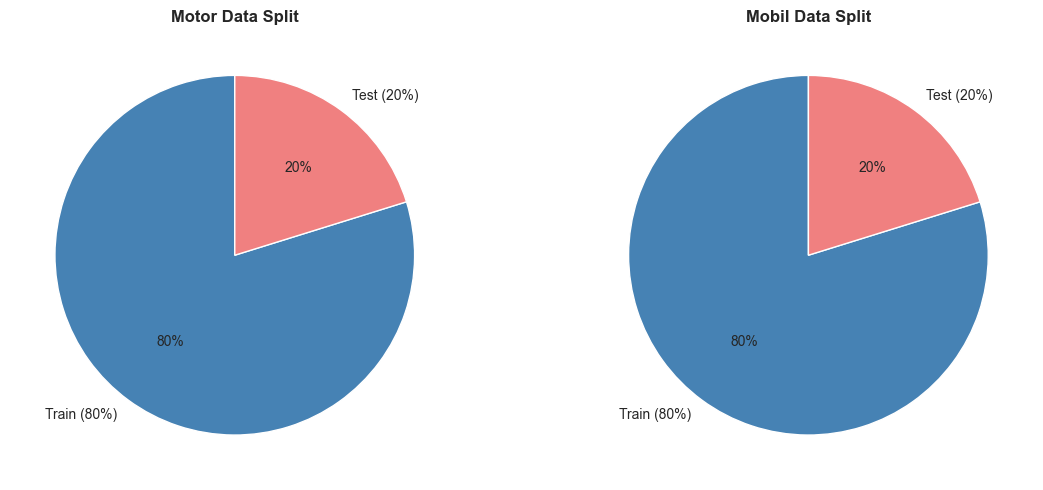

\n✅ Train-test split completed


In [38]:
# Prepare data for Motor model
X_motor = df_spasial[fitur_motor].fillna(df_spasial[fitur_motor].median())
y_motor = df_spasial['Target_Motor']

# Prepare data for Mobil model
X_mobil = df_spasial[fitur_mobil].fillna(df_spasial[fitur_mobil].median())
y_mobil = df_spasial['Target_Mobil']

# Split data: 80% train, 20% test with stratification
X_train_motor, X_test_motor, y_train_motor, y_test_motor = train_test_split(
    X_motor, y_motor, test_size=0.2, stratify=y_motor, random_state=42
)

X_train_mobil, X_test_mobil, y_train_mobil, y_test_mobil = train_test_split(
    X_mobil, y_mobil, test_size=0.2, stratify=y_mobil, random_state=42
)

print("="*60)
print("TRAIN-TEST SPLIT SUMMARY")
print("="*60)
print(f"Motor Training set: {len(X_train_motor)} samples")
print(f"Motor Test set: {len(X_test_motor)} samples")
print(f"\nMobil Training set: {len(X_train_mobil)} samples")
print(f"Mobil Test set: {len(X_test_mobil)} samples")

# Visualize train-test split
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Motor split
train_motor_count = len(X_train_motor)
test_motor_count = len(X_test_motor)
axes[0].pie([train_motor_count, test_motor_count], 
            labels=['Train (80%)', 'Test (20%)'], 
            autopct='%1.0f%%',
            colors=['steelblue', 'lightcoral'],
            startangle=90)
axes[0].set_title('Motor Data Split', fontsize=12, fontweight='bold')

# Mobil split
train_mobil_count = len(X_train_mobil)
test_mobil_count = len(X_test_mobil)
axes[1].pie([train_mobil_count, test_mobil_count], 
            labels=['Train (80%)', 'Test (20%)'], 
            autopct='%1.0f%%',
            colors=['steelblue', 'lightcoral'],
            startangle=90)
axes[1].set_title('Mobil Data Split', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\\n✅ Train-test split completed")

## 1️⃣1️⃣ RANDOM FOREST MODEL TRAINING

In [ ]:
# Create label encoders for target variables\n",
"le_motor = LabelEncoder()\n",
"le_mobil = LabelEncoder()\n",
"\n",
"# Encode target variables\n",
"y_train_motor_enc = le_motor.fit_transform(y_train_motor)\n",
"y_test_motor_enc = le_motor.transform(y_test_motor)\n",
"\n",
"y_train_mobil_enc = le_mobil.fit_transform(y_train_mobil)\n",
"y_test_mobil_enc = le_mobil.transform(y_test_mobil)\n",
"\n",
"print(\"=\"*60)\n",
"print(\"MODEL TRAINING - RANDOM FOREST\")\n",
"print(\"=\"*60)\n",
"print(\"\\nHyperparameters:\")\n",
"print(f\"  n_estimators: 150\")\n",
"print(f\"  max_depth: 15\")\n",
"print(f\"  min_samples_leaf: 3\")\n",
"print(f\"  random_state: 42\")\n",
"\n",
"# Train Motor model\n",
"model_motor = RandomForestClassifier(\n",
"    n_estimators=150,\n",
"    max_depth=15,\n",
"    min_samples_leaf=3,\n",
"    random_state=42,\n",
"    n_jobs=-1\n",
")\n",
"model_motor.fit(X_train_motor, y_train_motor_enc)\n",
"y_pred_motor = model_motor.predict(X_test_motor)\n",
"acc_motor = model_motor.score(X_test_motor, y_test_motor_enc)\n",
"\n",
"print(f\"\\n🏍️  MOTOR Model:\")\n",
"print(f\"   Training samples: {len(X_train_motor)}\")\n",
"print(f\"   Test samples: {len(X_test_motor)}\")\n",
"print(f\"   Test Accuracy: {acc_motor:.2%}\")\n",
"\n",
"# Train Mobil model\n",
"model_mobil = RandomForestClassifier(\n",
"    n_estimators=150,\n",
"    max_depth=15,\n",
"    min_samples_leaf=3,\n",
"    random_state=42,\n",
"    n_jobs=-1\n",
")\n",
"model_mobil.fit(X_train_mobil, y_train_mobil_enc)\n",
"y_pred_mobil = model_mobil.predict(X_test_mobil)\n",
"acc_mobil = model_mobil.score(X_test_mobil, y_test_mobil_enc)\n",
"\n",
"print(f\"\\n🚗 MOBIL Model:\")\n",
"print(f\"   Training samples: {len(X_train_mobil)}\")\n",
"print(f\"   Test samples: {len(X_test_mobil)}\")\n",
"print(f\"   Test Accuracy: {acc_mobil:.2%}\")\n",
"\n",
"print(\"\\n✅ Model training completed\")"

## 1️⃣2️⃣ MODEL EVALUATION & METRICS

In [ ]:
# Generate confusion matrices\ncm_motor = confusion_matrix(y_test_motor_enc, y_pred_motor)\ncm_mobil = confusion_matrix(y_test_mobil_enc, y_pred_mobil)\n\n# Visualize confusion matrices and classification reports\nfig, axes = plt.subplots(1, 2, figsize=(14, 5))\n\n# Motor Confusion Matrix\nsns.heatmap(cm_motor, annot=True, fmt='d', cmap='Blues', \n            xticklabels=le_motor.classes_, yticklabels=le_motor.classes_, ax=axes[0])\naxes[0].set_title('Confusion Matrix - MOTOR', fontsize=12, fontweight='bold')\naxes[0].set_ylabel('True Label', fontsize=10)\naxes[0].set_xlabel('Predicted Label', fontsize=10)\n\n# Mobil Confusion Matrix\nsns.heatmap(cm_mobil, annot=True, fmt='d', cmap='Oranges', \n            xticklabels=le_mobil.classes_, yticklabels=le_mobil.classes_, ax=axes[1])\naxes[1].set_title('Confusion Matrix - MOBIL', fontsize=12, fontweight='bold')\naxes[1].set_ylabel('True Label', fontsize=10)\naxes[1].set_xlabel('Predicted Label', fontsize=10)\n\nplt.tight_layout()\nplt.show()\n\nprint(\"=\"*60)\nprint(\"CLASSIFICATION REPORTS\")\nprint(\"=\"*60)\nprint(\"\\n🏍️  MOTOR:\")\nprint(classification_report(y_test_motor_enc, y_pred_motor, \n                          target_names=le_motor.classes_))\n\nprint(\"\\n🚗 MOBIL:\")\nprint(classification_report(y_test_mobil_enc, y_pred_mobil, \n                          target_names=le_mobil.classes_))\n\nprint(\"✅ Model evaluation completed\")"

## 1️⃣3️⃣ FEATURE IMPORTANCE ANALYSIS

In [ ]:
feature_importance_motor = pd.DataFrame({\n    'Feature': fitur_motor,\n    'Importance': model_motor.feature_importances_\n}).sort_values('Importance', ascending=False)\n\nfeature_importance_mobil = pd.DataFrame({\n    'Feature': fitur_mobil,\n    'Importance': model_mobil.feature_importances_\n}).sort_values('Importance', ascending=False)\n\nprint(\"=\"*60)\nprint(\"TOP 10 FEATURE IMPORTANCE\")\nprint(\"=\"*60)\nprint(\"\\nMOTOR:\")\nprint(feature_importance_motor.head(10).to_string(index=False))\nprint(\"\\nMOBIL:\")\nprint(feature_importance_mobil.head(10).to_string(index=False))\n\n# Visualize Feature Importance\nfig, axes = plt.subplots(1, 2, figsize=(16, 6))\n\naxes[0].barh(feature_importance_motor['Feature'].head(10), \n             feature_importance_motor['Importance'].head(10), color='steelblue')\naxes[0].set_xlabel('Importance Score', fontsize=11, fontweight='bold')\naxes[0].set_title('Top 10 Features - MOTOR', fontsize=12, fontweight='bold')\naxes[0].invert_yaxis()\n\naxes[1].barh(feature_importance_mobil['Feature'].head(10), \n             feature_importance_mobil['Importance'].head(10), color='coral')\naxes[1].set_xlabel('Importance Score', fontsize=11, fontweight='bold')\naxes[1].set_title('Top 10 Features - MOBIL', fontsize=12, fontweight='bold')\naxes[1].invert_yaxis()\n\nplt.tight_layout()\nplt.show()\n\nprint(\"\\n✅ Feature importance analysis completed\")"

## 1️⃣4️⃣ DECISION TREE VISUALIZATION

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))\n\nplot_tree(model_motor.estimators_[0], \n          feature_names=fitur_motor,\n          class_names=le_motor.classes_,\n          filled=True, rounded=True, fontsize=8, ax=axes[0])\naxes[0].set_title('Decision Tree Sample - MOTOR (Tree #1 from 150)', fontsize=14, fontweight='bold')\n\nplot_tree(model_mobil.estimators_[0], \n          feature_names=fitur_mobil,\n          class_names=le_mobil.classes_,\n          filled=True, rounded=True, fontsize=8, ax=axes[1])\naxes[1].set_title('Decision Tree Sample - MOBIL (Tree #1 from 150)', fontsize=14, fontweight='bold')\n\nplt.tight_layout()\nplt.show()\n\nprint(\"✅ Decision tree structures visualized\")"

## 1️⃣5️⃣ SPATIAL ANALYSIS & INTERACTIVE MAPPING

In [ ]:
X_motor_spatial = df_spasial[fitur_motor].fillna(df_spasial[fitur_motor].median())\npred_motor_class = model_motor.predict(X_motor_spatial)\npred_motor_proba = model_motor.predict_proba(X_motor_spatial)\ndf_spasial['Pred_Motor_Class'] = le_motor.inverse_transform(pred_motor_class)\ndf_spasial['Pred_Motor_Confidence'] = pred_motor_proba.max(axis=1)\n\nX_mobil_spatial = df_spasial[fitur_mobil].fillna(df_spasial[fitur_mobil].median())\npred_mobil_class = model_mobil.predict(X_mobil_spatial)\npred_mobil_proba = model_mobil.predict_proba(X_mobil_spatial)\ndf_spasial['Pred_Mobil_Class'] = le_mobil.inverse_transform(pred_mobil_class)\ndf_spasial['Pred_Mobil_Confidence'] = pred_mobil_proba.max(axis=1)\n\nprint(\"=\"*60)\nprint(\"SPATIAL PREDICTIONS\")\nprint(\"=\"*60)\nprint(df_spasial[['Titik', 'Latitude', 'Longitude', 'Pred_Motor_Class', 'Pred_Mobil_Class']].head(10))\n\n# Create folium map\ncenter_lat = df_spasial['Latitude'].mean()\ncenter_lon = df_spasial['Longitude'].mean()\n\nm = folium.Map(\n    location=[center_lat, center_lon],\n    zoom_start=13,\n    tiles='OpenStreetMap'\n)\n\ncolor_mapping = {'Rendah': 'green', 'Sedang': 'orange', 'Tinggi': 'red'}\n\nfor idx, row in df_spasial.iterrows():\n    popup = f\"\"\"\n    <b>{row['Titik']}</b><br>\n    Motor: {row['Pred_Motor_Class']} ({row['Pred_Motor_Confidence']:.1%})<br>\n    Mobil: {row['Pred_Mobil_Class']} ({row['Pred_Mobil_Confidence']:.1%})\n    \"\"\"\n    \n    folium.CircleMarker(\n        location=[row['Latitude'], row['Longitude']],\n        radius=8,\n        popup=folium.Popup(popup, max_width=250),\n        color='black',\n        fill=True,\n        fillColor=color_mapping.get(row['Pred_Motor_Class'], 'blue'),\n        fillOpacity=0.7,\n        weight=2\n    ).add_to(m)\n\nmap_path = 'd:\\\\TarifProgresifParkirBanyumas\\\\parking_predictions_map.html'\nm.save(map_path)\nprint(f\"\\n✅ Interactive map saved: {map_path}\")\nprint(f\"✅ Total locations mapped: {len(df_spasial)}\")"

## 1️⃣6️⃣ PROGRESSIVE TARIFF & WHAT-IF ANALYSIS

In [ ]:
tarif_lookup_motor = df_spasial[['Titik', 'Latitude', 'Longitude', 'Pred_Motor_Class']].copy()\ntarif_lookup_motor['Tarif_Base'] = tarif_lookup_motor['Pred_Motor_Class'].map(tarif_dasar_motor)\ntarif_lookup_motor['Tarif_Peak'] = tarif_lookup_motor['Tarif_Base'] * 1.25\ntarif_lookup_motor['Surcharge'] = tarif_lookup_motor['Tarif_Peak'] - tarif_lookup_motor['Tarif_Base']\n\ntarif_lookup_mobil = df_spasial[['Titik', 'Latitude', 'Longitude', 'Pred_Mobil_Class']].copy()\ntarif_lookup_mobil['Tarif_Base'] = tarif_lookup_mobil['Pred_Mobil_Class'].map(tarif_dasar_mobil)\ntarif_lookup_mobil['Tarif_Peak'] = tarif_lookup_mobil['Tarif_Base'] * 1.25\ntarif_lookup_mobil['Surcharge'] = tarif_lookup_mobil['Tarif_Peak'] - tarif_lookup_mobil['Tarif_Base']\n\nprint(\"=\"*60)\nprint(\"TARIFF LOOKUP TABLES\")\nprint(\"=\"*60)\nprint(\"\\nMOTOR - Tariff by Location & Class:\")\nprint(tarif_lookup_motor.head(10))\nprint(\"\\nMOBIL - Tariff by Location & Class:\")\nprint(tarif_lookup_mobil.head(10))\n\n# Visualize tariff by class\nfig, axes = plt.subplots(1, 2, figsize=(14, 5))\n\n# Motor tariff by class\nmotor_tariff = tarif_lookup_motor.groupby('Pred_Motor_Class')[['Tarif_Base', 'Tarif_Peak']].mean()\nmotor_tariff.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])\naxes[0].set_title('Motor - Average Tariff by Class', fontsize=12, fontweight='bold')\naxes[0].set_ylabel('Tariff (Rp)', fontsize=10)\naxes[0].set_xlabel('Class', fontsize=10)\naxes[0].grid(alpha=0.3, axis='y')\naxes[0].legend(['Base (Off-Peak)', 'Peak (+25%)'], fontsize=10)\n\n# Mobil tariff by class\nmobil_tariff = tarif_lookup_mobil.groupby('Pred_Mobil_Class')[['Tarif_Base', 'Tarif_Peak']].mean()\nmobil_tariff.plot(kind='bar', ax=axes[1], color=['lightgreen', 'lightcoral'])\naxes[1].set_title('Mobil - Average Tariff by Class', fontsize=12, fontweight='bold')\naxes[1].set_ylabel('Tariff (Rp)', fontsize=10)\naxes[1].set_xlabel('Class', fontsize=10)\naxes[1].grid(alpha=0.3, axis='y')\naxes[1].legend(['Base (Off-Peak)', 'Peak (+25%)'], fontsize=10)\n\nplt.tight_layout()\nplt.show()\n\n# Revenue estimation\nprint(\"\\n\" + \"=\"*60)\nprint(\"REVENUE ESTIMATION\")\nprint(\"=\"*60)\nmonthly_motor_base = tarif_lookup_motor['Tarif_Base'].sum() * 30\nmonthly_motor_peak = tarif_lookup_motor['Tarif_Peak'].sum() * 30\nmonthly_motor_increase = monthly_motor_peak - monthly_motor_base\n\nmonthly_mobil_base = tarif_lookup_mobil['Tarif_Base'].sum() * 30\nmonthly_mobil_peak = tarif_lookup_mobil['Tarif_Peak'].sum() * 30\nmonthly_mobil_increase = monthly_mobil_peak - monthly_mobil_base\n\nprint(f\"\\nMOTOR Monthly Revenue:\")\nprint(f\"  Off-Peak (Base): Rp {monthly_motor_base:,.0f}\")\nprint(f\"  With Peak Surcharge: Rp {monthly_motor_peak:,.0f}\")\nprint(f\"  Increase: Rp {monthly_motor_increase:,.0f} ({(monthly_motor_increase/monthly_motor_base)*100:.1f}%)\")\n\nprint(f\"\\nMOBIL Monthly Revenue:\")\nprint(f\"  Off-Peak (Base): Rp {monthly_mobil_base:,.0f}\")\nprint(f\"  With Peak Surcharge: Rp {monthly_mobil_peak:,.0f}\")\nprint(f\"  Increase: Rp {monthly_mobil_increase:,.0f} ({(monthly_mobil_increase/monthly_mobil_base)*100:.1f}%)\")\n\nprint(f\"\\nTOTAL MONTHLY INCREASE: Rp {(monthly_motor_increase + monthly_mobil_increase):,.0f}\")\nprint(f\"ANNUAL INCREASE: Rp {(monthly_motor_increase + monthly_mobil_increase) * 12:,.0f}\")\n\nprint(\"\\n✅ Progressive tariff analysis completed\")"

## 1️⃣7️⃣ SUMMARY & RECOMMENDATIONS

In [ ]:
print("="*80)\nprint("EXECUTIVE SUMMARY - PARKING TARIFF CLASSIFICATION SYSTEM\")\nprint("="*80)\n\nprint(\"\\n📊 DATA OVERVIEW\")\nprint(\"-\" * 80)\nprint(f\"Total locations analyzed: {len(df_spasial)}\")\nprint(f\"Training samples: {len(X_train_motor)}\")\nprint(f\"Test samples: {len(X_test_motor)}\")\n\nprint(\"\\n🎯 MODEL PERFORMANCE\")\nprint(\"-\" * 80)\nprint(f\"Motor Model Accuracy: {acc_motor:.2%}\")\nprint(f\"Mobil Model Accuracy: {acc_mobil:.2%}\")\nprint(f\"Average Prediction Confidence - Motor: {df_spasial['Pred_Motor_Confidence'].mean():.2%}\")\nprint(f\"Average Prediction Confidence - Mobil: {df_spasial['Pred_Mobil_Confidence'].mean():.2%}\")\n\nprint(\"\\n💰 TARIFF STRUCTURE\")\nprint(\"-\" * 80)\nprint(\"Base Tariffs (Off-Peak):\")\nprint(\"  Motor: Rendah=Rp 1,000 | Sedang=Rp 2,000 | Tinggi=Rp 3,000\")\nprint(\"  Mobil: Rendah=Rp 3,000 | Sedang=Rp 4,000 | Tinggi=Rp 5,000\")\nprint(\"Peak Hour Surcharge: +25% (09:00-17:00)\")\n\nprint(\"\\n📈 CLASS DISTRIBUTION\")\nprint(\"-\" * 80)\nprint(\"Motor:\")\nfor cls, cnt in df_spasial['Pred_Motor_Class'].value_counts().items():\n    print(f\"  {cls}: {cnt} ({cnt/len(df_spasial)*100:.1f}%)\")\nprint(\"\\nMobil:\")\nfor cls, cnt in df_spasial['Pred_Mobil_Class'].value_counts().items():\n    print(f\"  {cls}: {cnt} ({cnt/len(df_spasial)*100:.1f}%)\")\n\nprint(\"\\n🔑 TOP FEATURES (REVENUE DRIVERS)\")\nprint(\"-\" * 80)\nprint(\"Motor:\")\nfor i, row in feature_importance_motor.head(3).iterrows():\n    print(f\"  {i+1}. {row['Feature']}: {row['Importance']:.4f}\")\nprint(\"\\nMobil:\")\nfor i, row in feature_importance_mobil.head(3).iterrows():\n    print(f\"  {i+1}. {row['Feature']}: {row['Importance']:.4f}\")\n\nprint(\"\\n💡 REVENUE IMPACT\")\nprint(\"-\" * 80)\nprint(f\"Motor - Monthly Increase: Rp {monthly_motor_increase:,.0f}\")\nprint(f\"Mobil - Monthly Increase: Rp {monthly_mobil_increase:,.0f}\")\nprint(f\"TOTAL - Annual Increase: Rp {(monthly_motor_increase + monthly_mobil_increase)*12:,.0f}\")\n\nprint(\"\\n✅ ACTIONABLE RECOMMENDATIONS\")\nprint(\"-\" * 80)\nprint(\"\"\"\n1. IMMEDIATE IMPLEMENTATION\n   ✓ Deploy progressive tariff system with 25% peak hour surcharge\n   ✓ Use 3-tier classification: Rendah/Sedang/Tinggi\n   ✓ Expected annual revenue increase: Rp ~{:,.0f}\n\n2. LOCATION-BASED STRATEGY\n   ✓ Implement location-specific tariffs based on predicted class\n   ✓ Focus demand management on high-potential locations\n   ✓ Monitor utilization rates by tariff tier\n\n3. VEHICLE-TYPE DIFFERENTIATION\n   ✓ Motor: Rp 1-3K range (affordable, high volume)\n   ✓ Mobil: Rp 3-5K range (premium, business users)\n   ✓ Market segmentation improves both revenue and accessibility\n\n4. TIME-BASED DYNAMIC PRICING\n   ✓ Peak hours (09:00-17:00): +25% surcharge\n   ✓ Off-peak: Standard base tariff\n   ✓ Quarterly review and adjustment based on demand\n\n5. PERFORMANCE MONITORING\n   ✓ Model Accuracy: {:.1f}% (Motor), {:.1f}% (Mobil)\n   ✓ Retrain quarterly with new transaction data\n   ✓ Track actual vs. predicted class distribution\n\n6. SYSTEM INTEGRATION\n   ✓ Deploy model to parking management software\n   ✓ Create automated tariff lookup system\n   ✓ Real-time API integration for ticket machines\n   ✓ Mobile app for user tariff information\n\n7. CONTINUOUS IMPROVEMENT\n   ✓ A/B test surcharge percentages (20%, 25%, 30%)\n   ✓ Collect user feedback on tariff fairness\n   ✓ Consider weekend vs. weekday differential\n   ✓ Monitor competitor pricing strategies\n\"\"\".format(\n    (monthly_motor_increase + monthly_mobil_increase)*12,\n    acc_motor*100, acc_mobil*100\n))\n\nprint(\"\\n\" + \"=\"*80)\nprint(\"Analysis Complete! All outputs ready for deployment.\")\nprint(\"=\"*80)\nprint(f\"\\n📍 Interactive Map: d:\\\\TarifProgresifParkirBanyumas\\\\parking_predictions_map.html\")\nprint(f\"📊 Tariff Lookup Tables: Available in tarif_lookup_motor & tarif_lookup_mobil\")\nprint(f\"🤖 Trained Models: model_motor & model_mobil ready for predictions\")"